In [79]:
import numpy as np
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import matplotlib
import os
matplotlib.rcParams['font.size'] = 12
plt.rcParams.update({'figure.figsize':[18,6]})
from matplotlib import cm
import sys
import pyhsmm
from pyhsmm.util.general import rle
import pyhsmm.basic.distributions as distributions
from scipy.stats import entropy
sys.path.append('/home/kirilman/Project/hmm/')
sys.path.append('/home/kirilman/Projects/nir/main nir')
from sequence_generator import SemiMarkovSignal

from pyhsmm.util.text import progprint_xrange
from multiprocessing import Pool

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

def do_log_likelihood(args):
    model, data = args
    ll = []
    for x in data:
        ll += [model.log_likelihood(x.reshape(-1,1))]
    return np.array(ll)

In [3]:
#fit model
def create_model(data, Nmax = 5):
    obs_dim = 1
    dur_distns = []
    Nmax = 5
#     L = 5
#     obs_hypparams = {'alpha_0':np.zeros(L)+0.1,
#                     'K':L,
#                      'alphav_0':np.zeros(L)+0.1, 
#                      'alpha_mf':np.zeros(L)+0.1,
#                     }

    obs_hypparams = {'mu_0':np.zeros(obs_dim),
                    'sigma_0':np.eye(obs_dim),
                    'kappa_0':2,
                    'nu_0':obs_dim+5}
    obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]

    
    dur_hypparams = {'alpha_0':45,
                     'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':20,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':30,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':55,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    
    
    dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

    posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
            alpha=6.,gamma=2., # better to sample over these; see concentration-resampling.py
            init_state_concentration=6., # pretty inconsequential
            obs_distns=obs_distns,
            dur_distns=dur_distns)

#     posteriormodel = pyhsmm.models.HSMM(
#             alpha=6., # На что влияет 
# #             gamma=2., # better to sample over these; see concentration-resampling.py
#             init_state_concentration=6., # pretty inconsequential
#             obs_distns=obs_distns,
#             dur_distns=dur_distns)
    
    posteriormodel.add_data(data) # duration truncation speeds things up when it's possible
    
    fig = plt.figure(figsize=(12,10),dpi = 140)
    for idx in progprint_xrange(150):
        posteriormodel.resample_model(1)
    plt.show()
    return posteriormodel

from multiprocessing import Pool
class hsmm_classifier():
    def __init__(self, N = 5):
        self.models = []
        self.number_model = N
        
    def fit(self,data):
        pool = Pool(4)
        params = [ (data, i + 10) for i in range(self.number_model)]
        self.models = pool.starmap(self.create_model, params)
        pool.close()
        pool.join()
    def log_likelihood(self, data):
#         pool = Pool(self.number_model)
#         return pool(self.models.log_likelihood, [(data,)*self.number_model])
        return np.array([m.log_likelihood(data) for m in self.models])
    
    def test(self):
        for m in self.models:
            print(m.generate(10,1))
            
    def create_model(self,data,seed):
        np.random.seed(seed)
        obs_dim = 1
        dur_distns = []
        Nmax = 7
    #     L = 5
    #     obs_hypparams = {'alpha_0':np.zeros(L)+0.1,
    #                     'K':L,
    #                      'alphav_0':np.zeros(L)+0.1, 
    #                      'alpha_mf':np.zeros(L)+0.1,
    #                     }

        obs_hypparams = {'mu_0':np.zeros(obs_dim),
                        'sigma_0':np.eye(obs_dim),
                        'kappa_0':2,
                        'nu_0':obs_dim+5}
        obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]


        dur_hypparams = {'alpha_0':45,
                         'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    #     dur_hypparams = {'alpha_0':20,
    #                      'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    #     dur_hypparams = {'alpha_0':30,
    #                      'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    #     dur_hypparams = {'alpha_0':55,
    #                      'beta_0':1}
#         dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]

#         dur_distns = [distributions.GeometricDuration(**dur_hypparams) for state in range(Nmax)]

        dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

        posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
                alpha=6.,gamma=2., # better to sample over these; see concentration-resampling.py
                init_state_concentration=6., # pretty inconsequential
                obs_distns=obs_distns,
                dur_distns=dur_distns)

    #     posteriormodel = pyhsmm.models.HSMM(
    #             alpha=6., # На что влияет 
    # #             gamma=2., # better to sample over these; see concentration-resampling.py
    #             init_state_concentration=6., # pretty inconsequential
    #             obs_distns=obs_distns,
    #             dur_distns=dur_distns)

        posteriormodel.add_data(data) # duration truncation speeds things up when it's possible
        for idx in progprint_xrange(150):
            posteriormodel.resample_model(1)
        return posteriormodel
    def get_models(self):
        return self.models

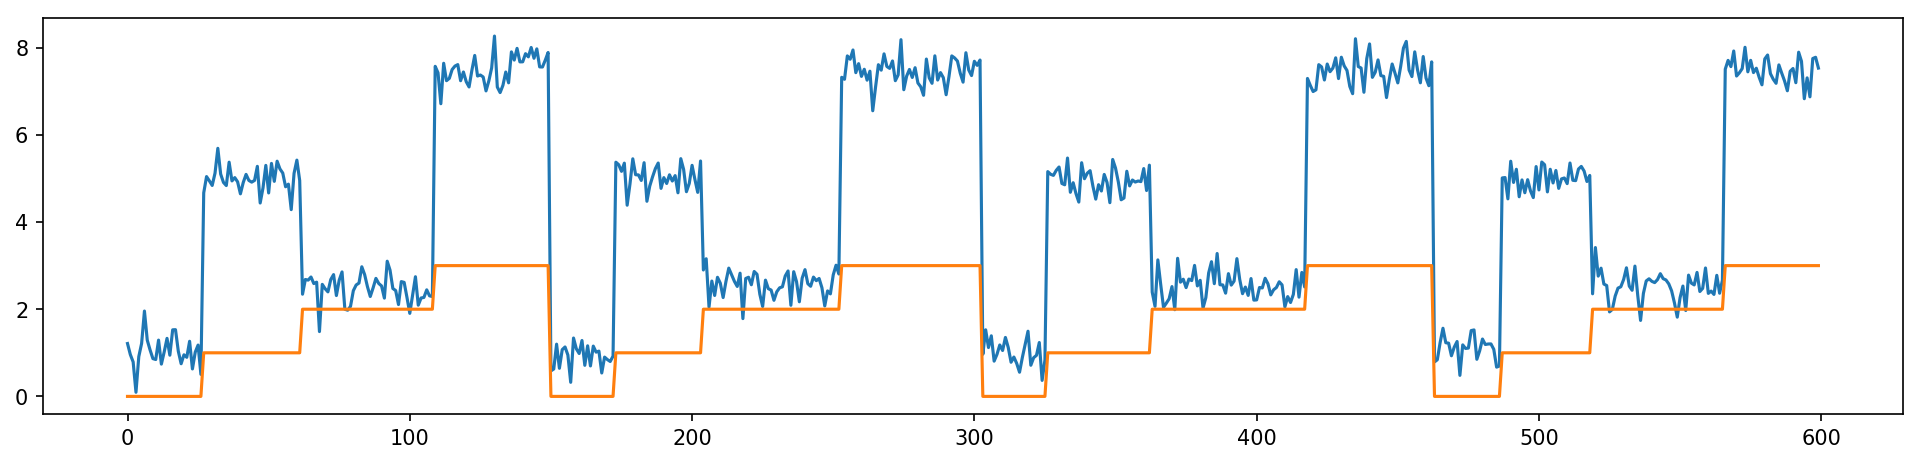

In [4]:
means = [1,5,2.5,7.5] 
variance=[0.3, 0.3, 0.3, 0.3]

trans_matrix = [[0.0, 1.0, 0.0, 0.0],
                 [0.0, 0.0, 1.0, 0.0],
                 [0.0, 0.0, 0.0, 1.0],
                 [1.0, 0.0, 0,0, 0.0]]

init_dist=[1.0, 0.0, 0.0, 0.0]
dur_param = [25, 35, 45, 45]
N = 4 
T = 600

signal = SemiMarkovSignal(_means = means, _variance = variance, _trans_matrix = trans_matrix,
                 _init_dist=init_dist,_dur_param = dur_param,  _N = N, _T=T)

plt.figure(dpi = 150, figsize=(16,3.5))
plt.plot(signal.sequence)
plt.plot(signal.stateseq)

In [6]:
# s = SemiMarkovSignal(_means = [0,2,4], _varience=[0.3, 0.5, 0.2], _trans_matrix = [[0.0, 0.7, 0.3],
#                                                                                    [0.5, 0.0, 0.5],
#                                                                                    [0.2, 0.8, 0.0]],
#                  _init_dist=[0, 1.0, 0.0, 0.0],_dur_param = [20,100,30],  _N = 3, T=2500)
# plt.figure(dpi = 150, figsize=(16,3.5))
# plt.plot(s.sequence)
# plt.plot(s.stateseq)

In [7]:
# model = create_model(s.sequence.reshape(-1,1), Nmax=3)

In [8]:
classifiear = hsmm_classifier(N = 3)
classifiear.fit(signal.sequence.reshape(-1,1))

/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


.....................................................................  [  25/150,    0.12sec avg, ETA 15.02 ]
....  [  25/150,    0.13sec avg, ETA 16.07 ]
......  [  25/150,    0.14sec avg, ETA 17.13 ]
.................................................................  [  50/150,    0.12sec avg, ETA 12.32 ]
.....  [  50/150,    0.13sec avg, ETA 12.86 ]
....  [  50/150,    0.13sec avg, ETA 13.00 ]
.................................................................  [  75/150,    0.12sec avg, ETA 9.22 ]
..  [  75/150,    0.12sec avg, ETA 9.37 ]
...............  [  75/150,    0.13sec avg, ETA 9.94 ]
........................................................  [ 100/150,    0.12sec avg, ETA 6.01 ]
..  [ 100/150,    0.12sec avg, ETA 6.05 ]
......................  [ 100/150,    0.13sec avg, ETA 6.53 ]
................................................  [ 125/150,    0.12sec avg, ETA 3.05 ]
..  [ 125/150,    0.12sec avg, ETA 3.07 ]
...........................  [ 125/150,    0.13sec avg, ETA 3.28 ]
..

In [180]:
list_of_anomalies = ['varience','extension', 'chain_violation']
plt.style.use('seaborn-paper')
matplotlib.rcParams['font.size'] = 25

varience
200 200
400 600


/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


extension
200 200
400 600


/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


chain_violation
200 200
400 600


/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


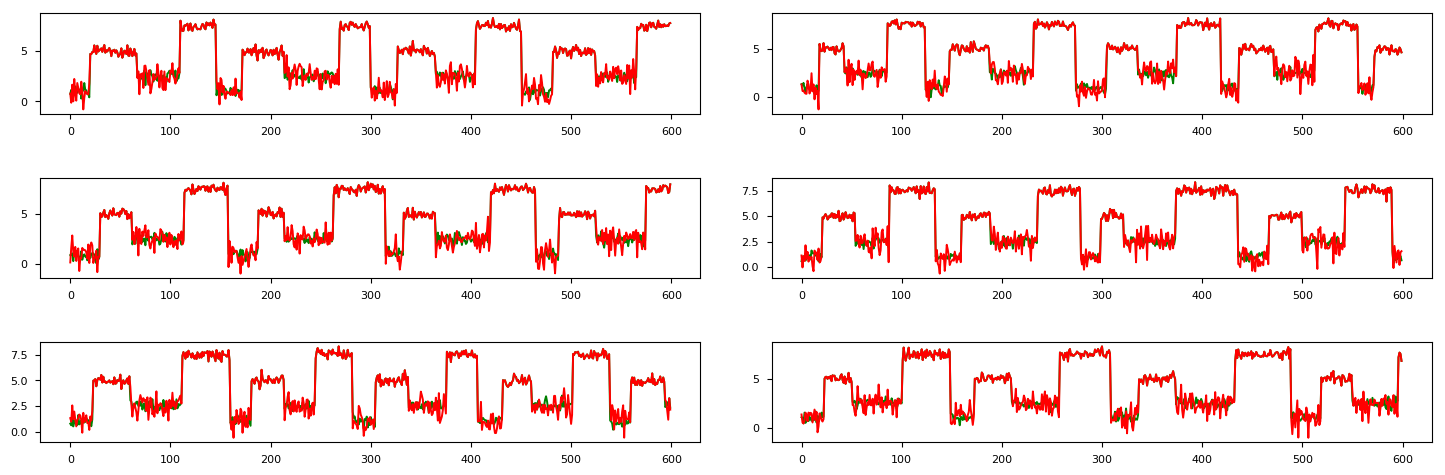

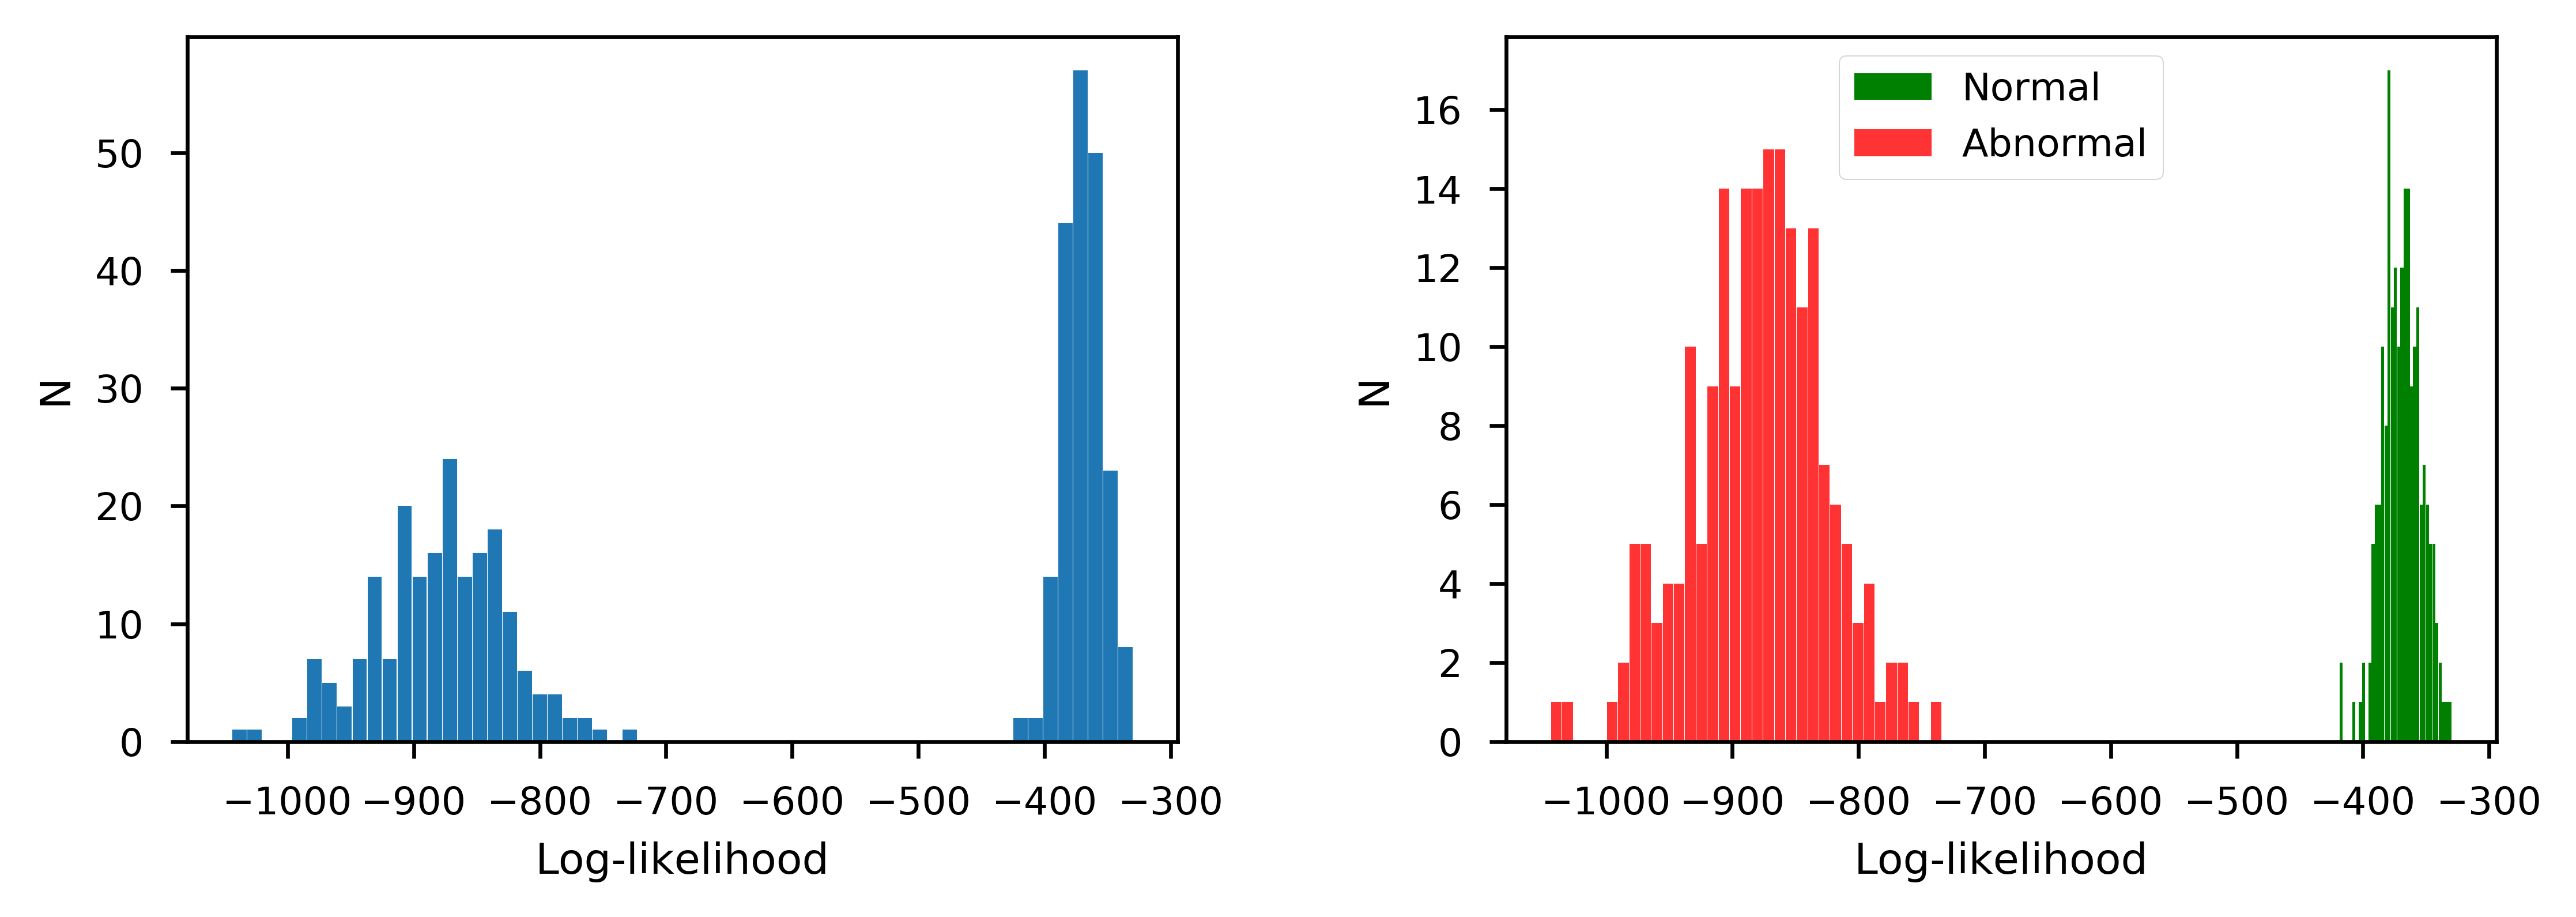

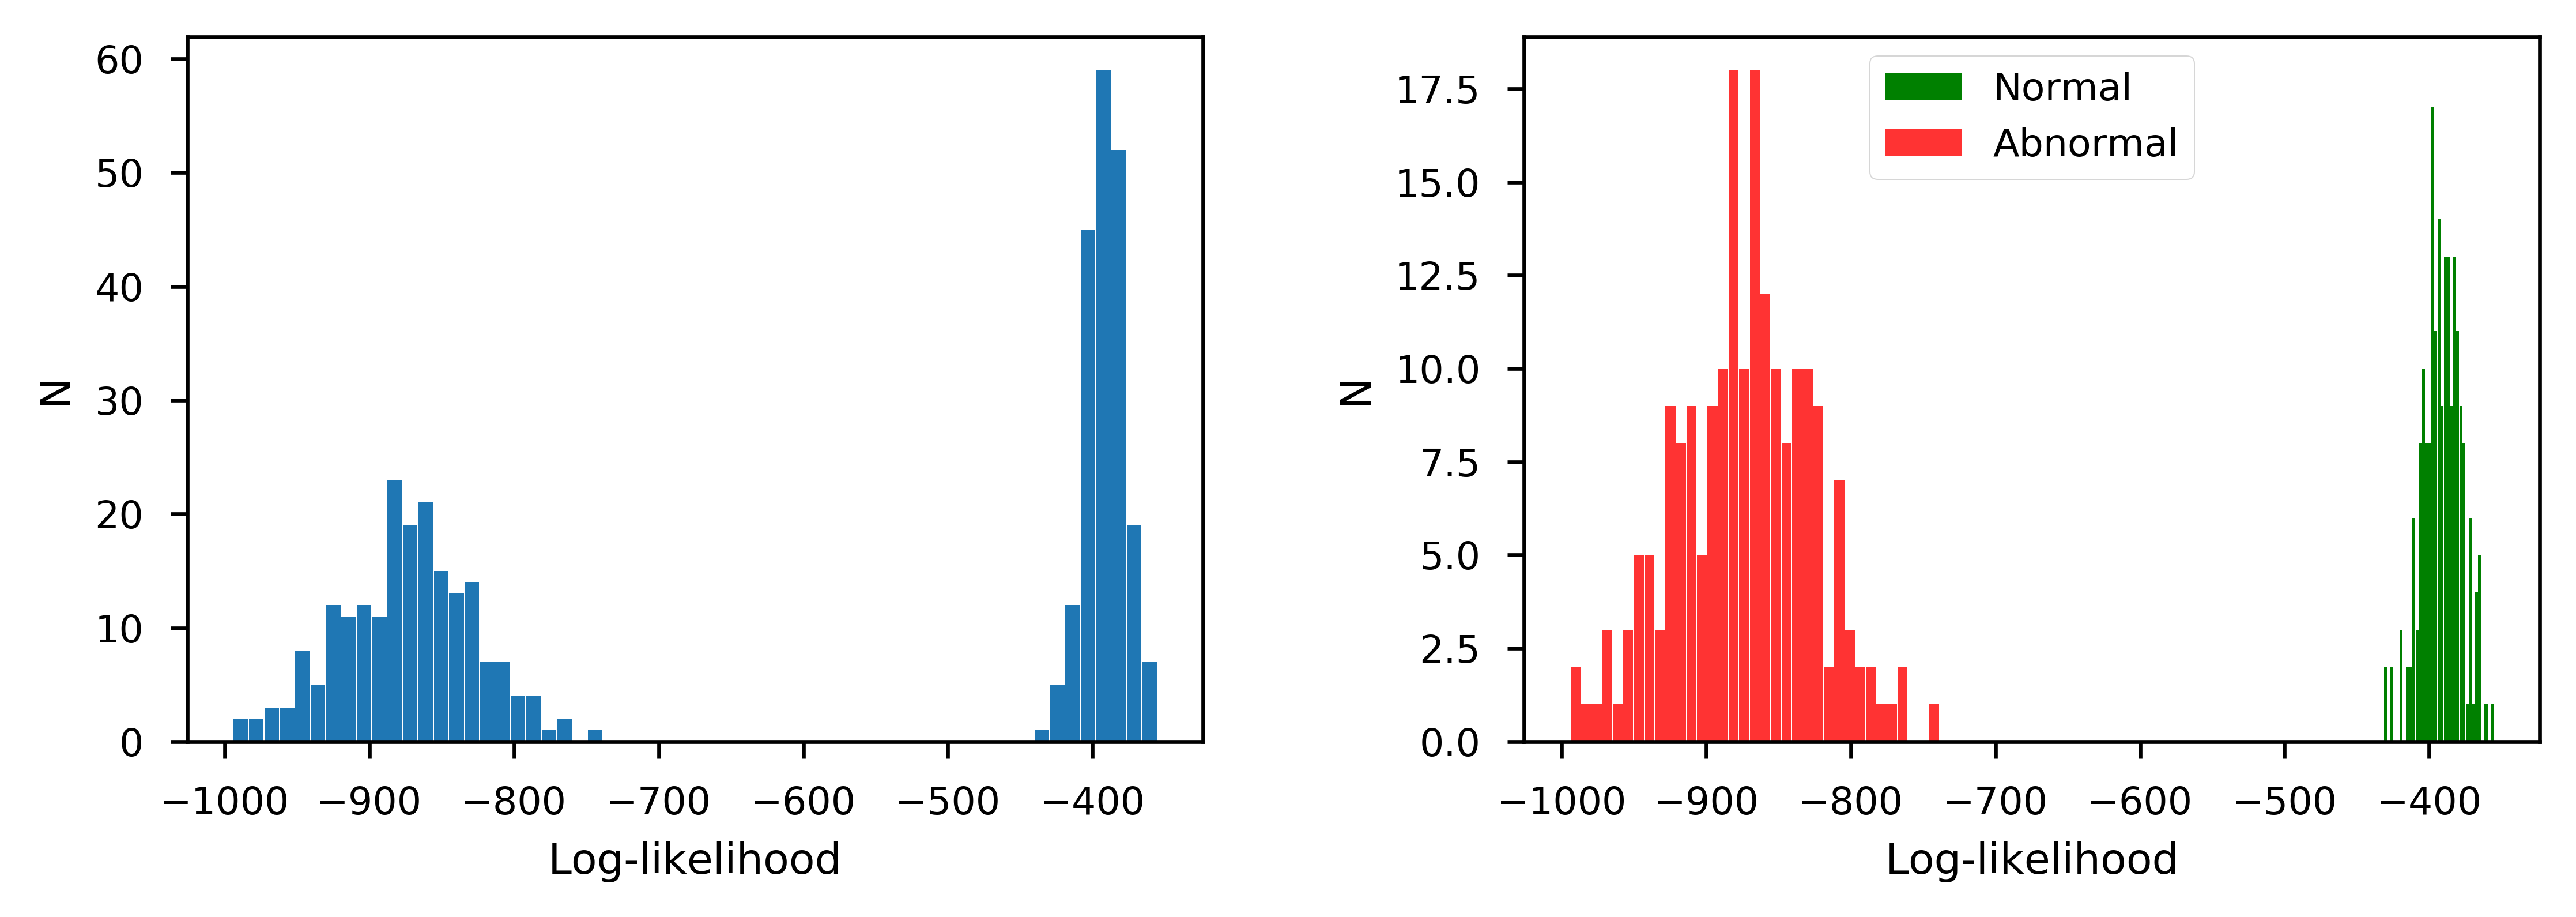

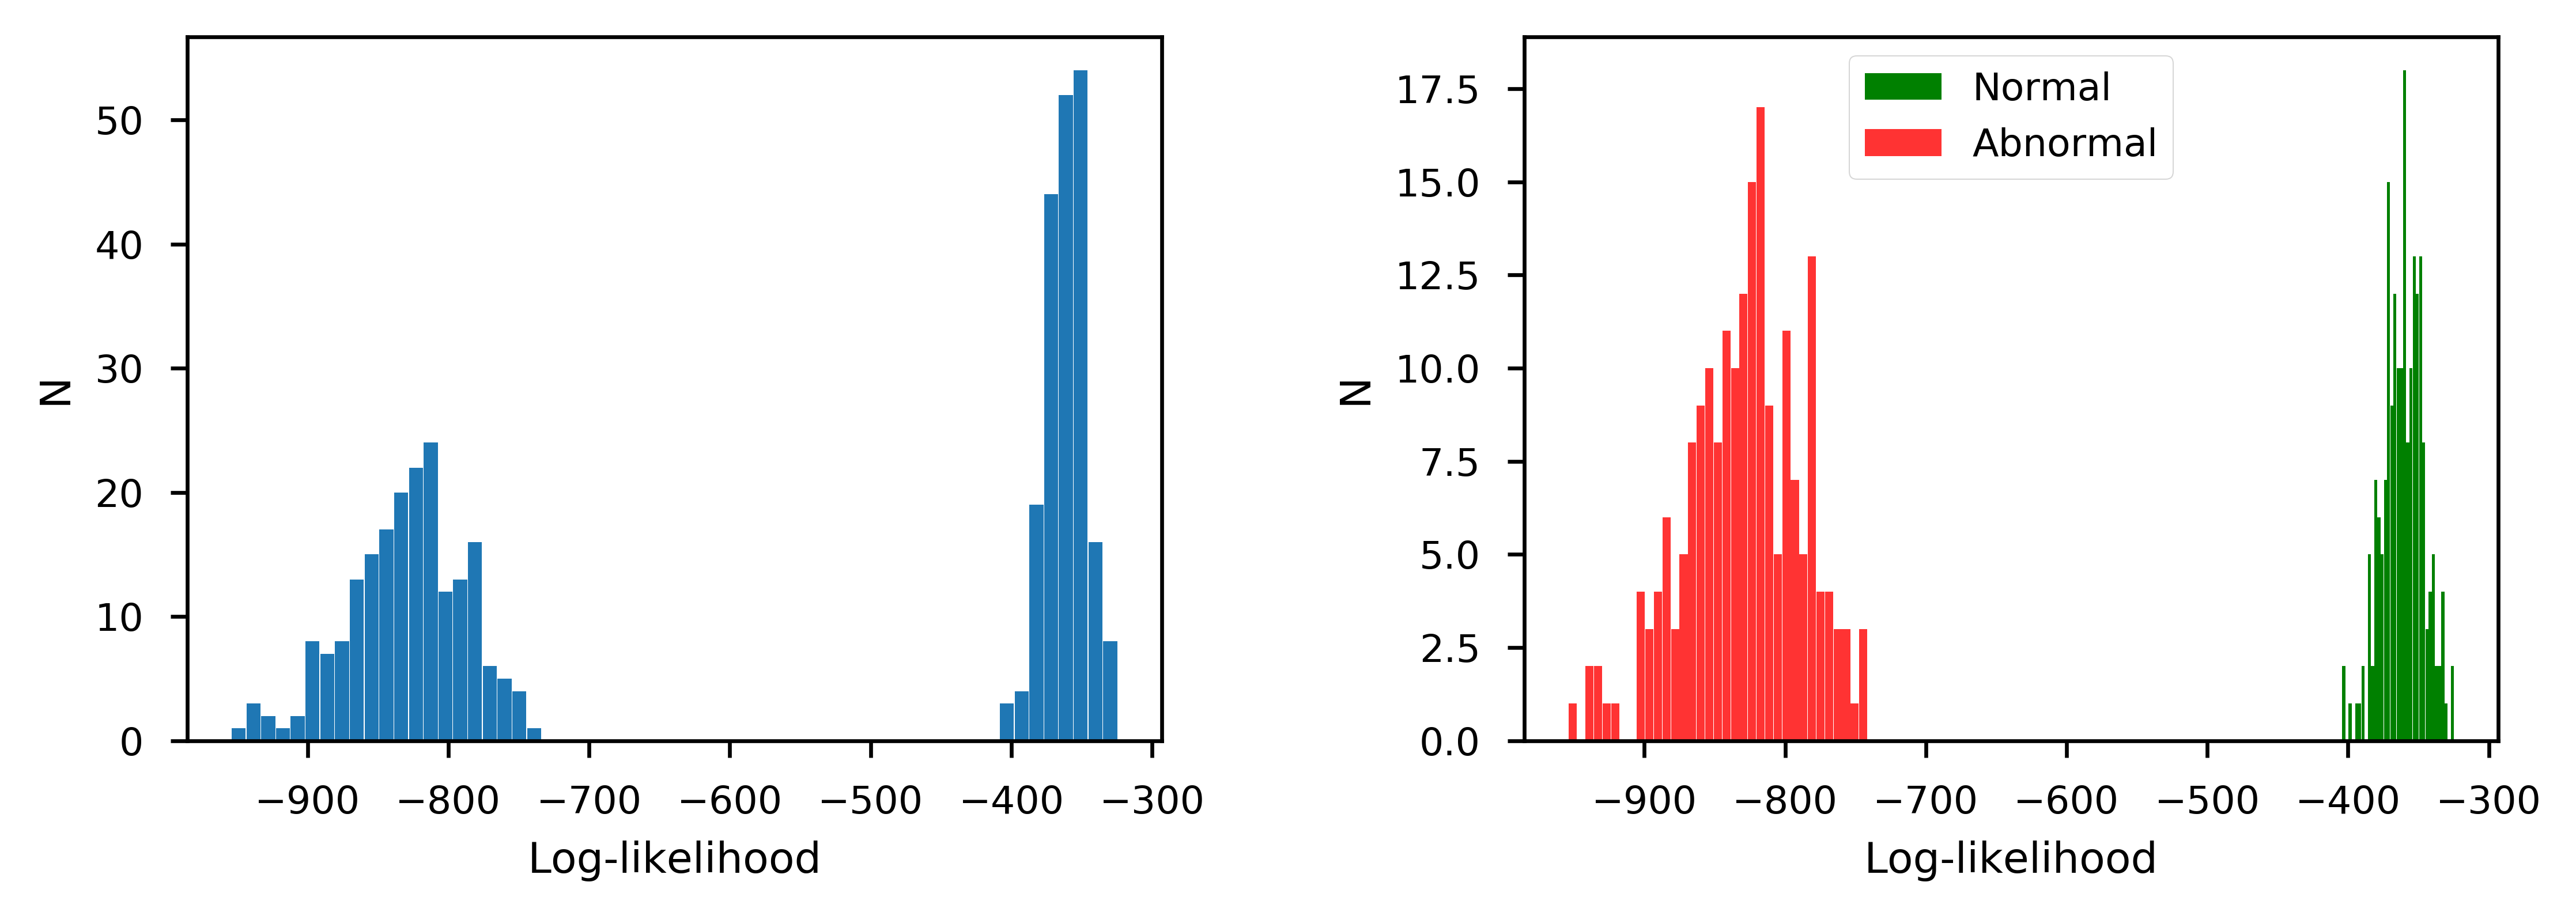

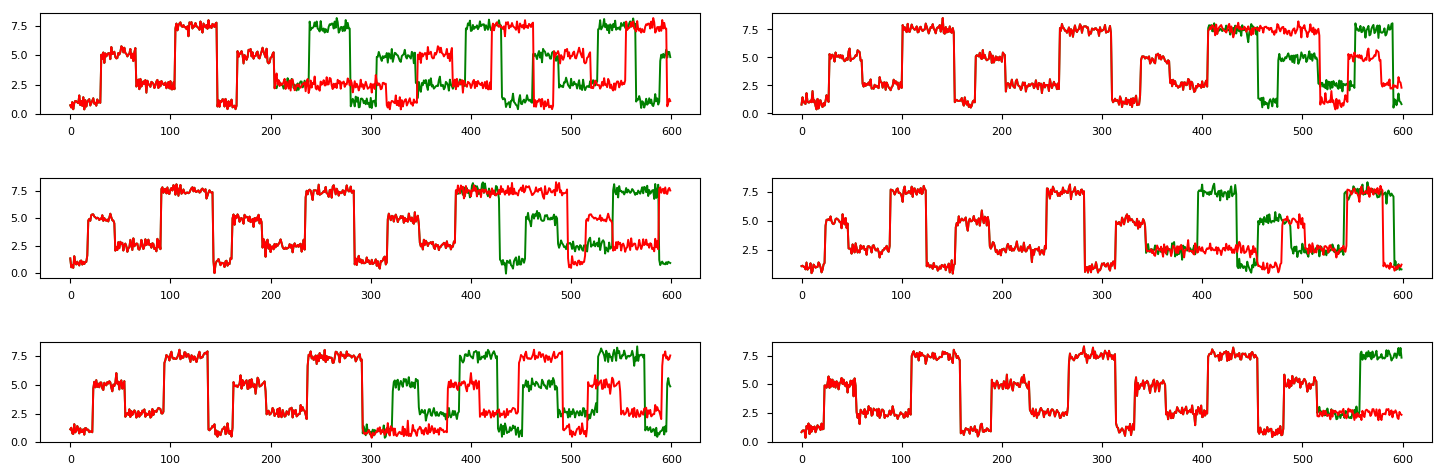

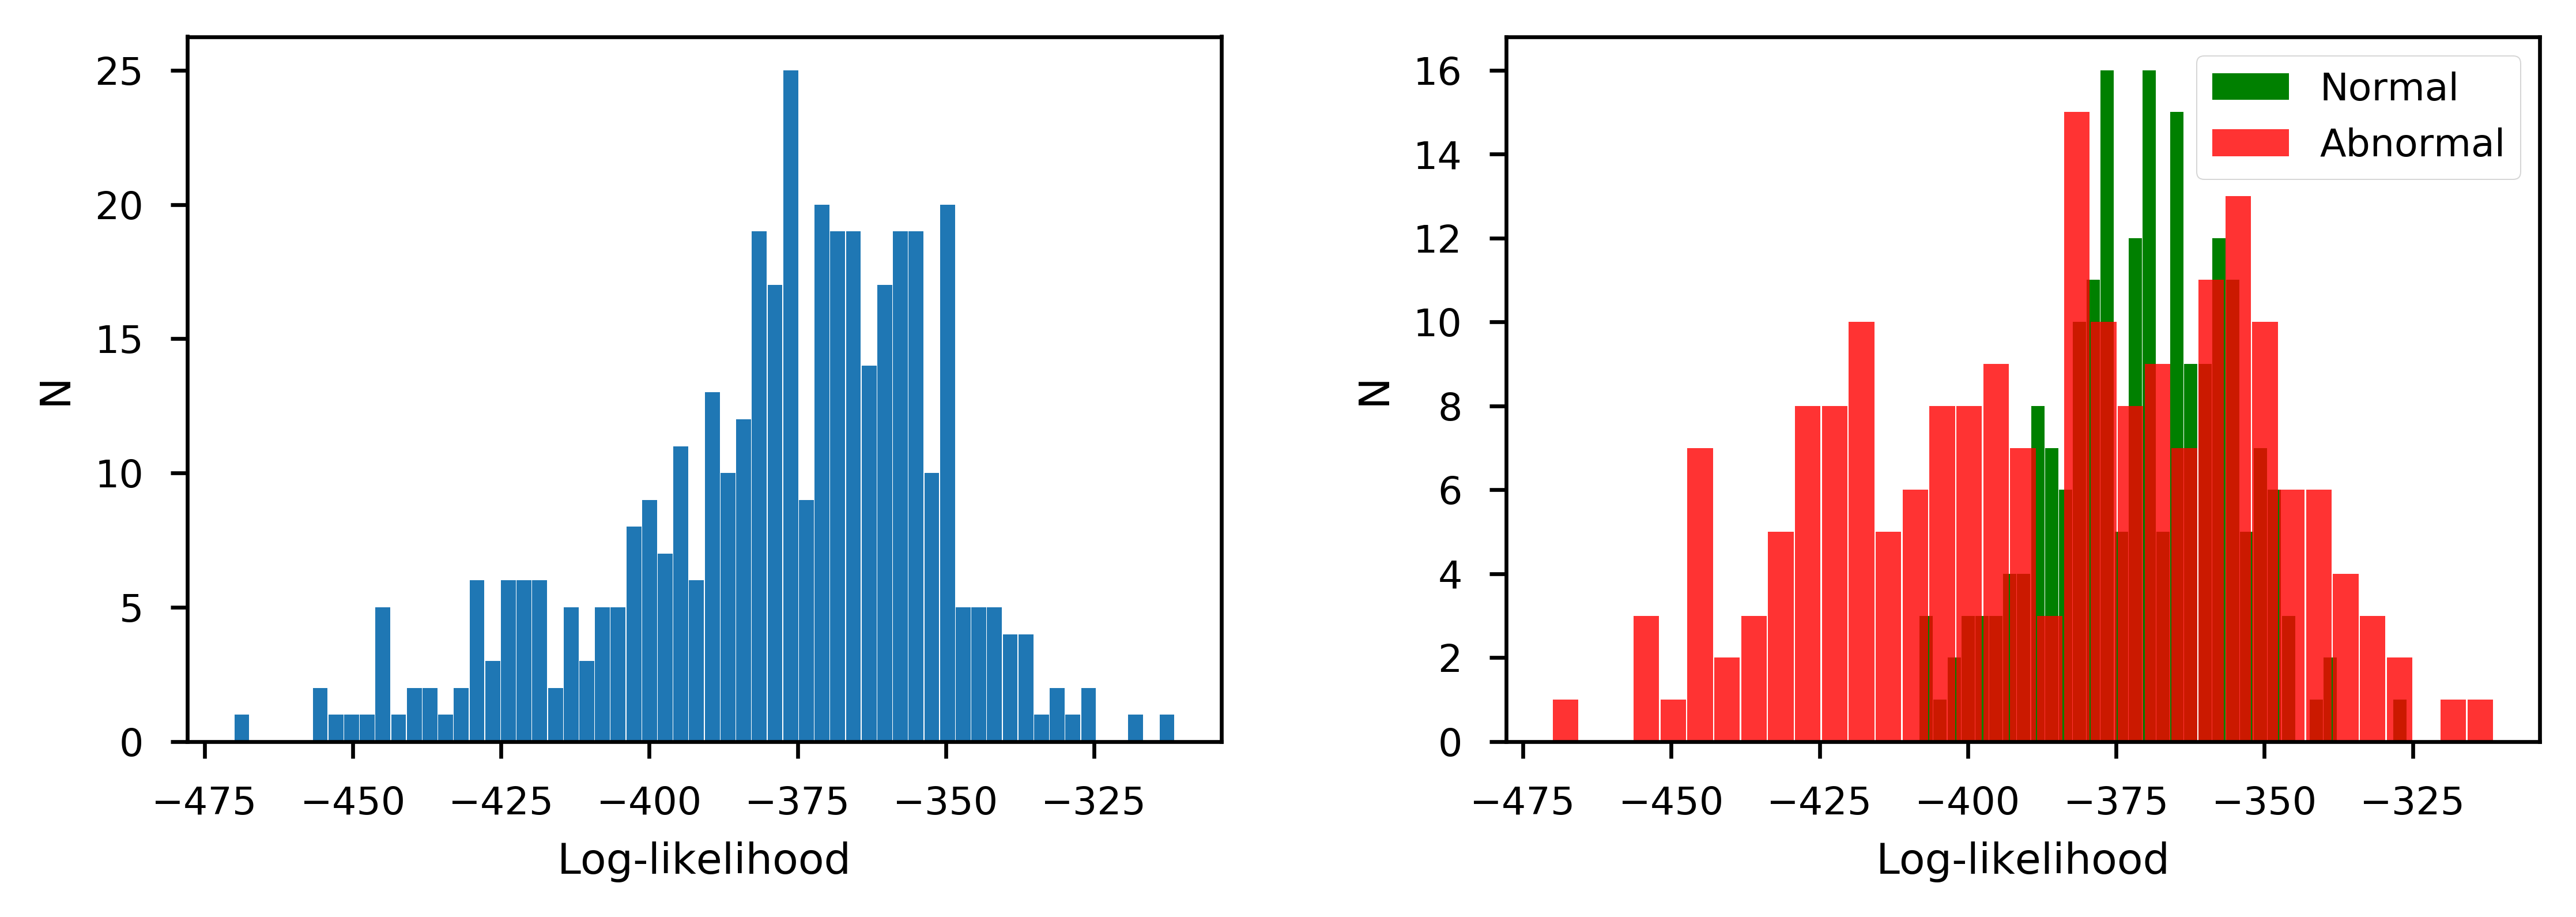

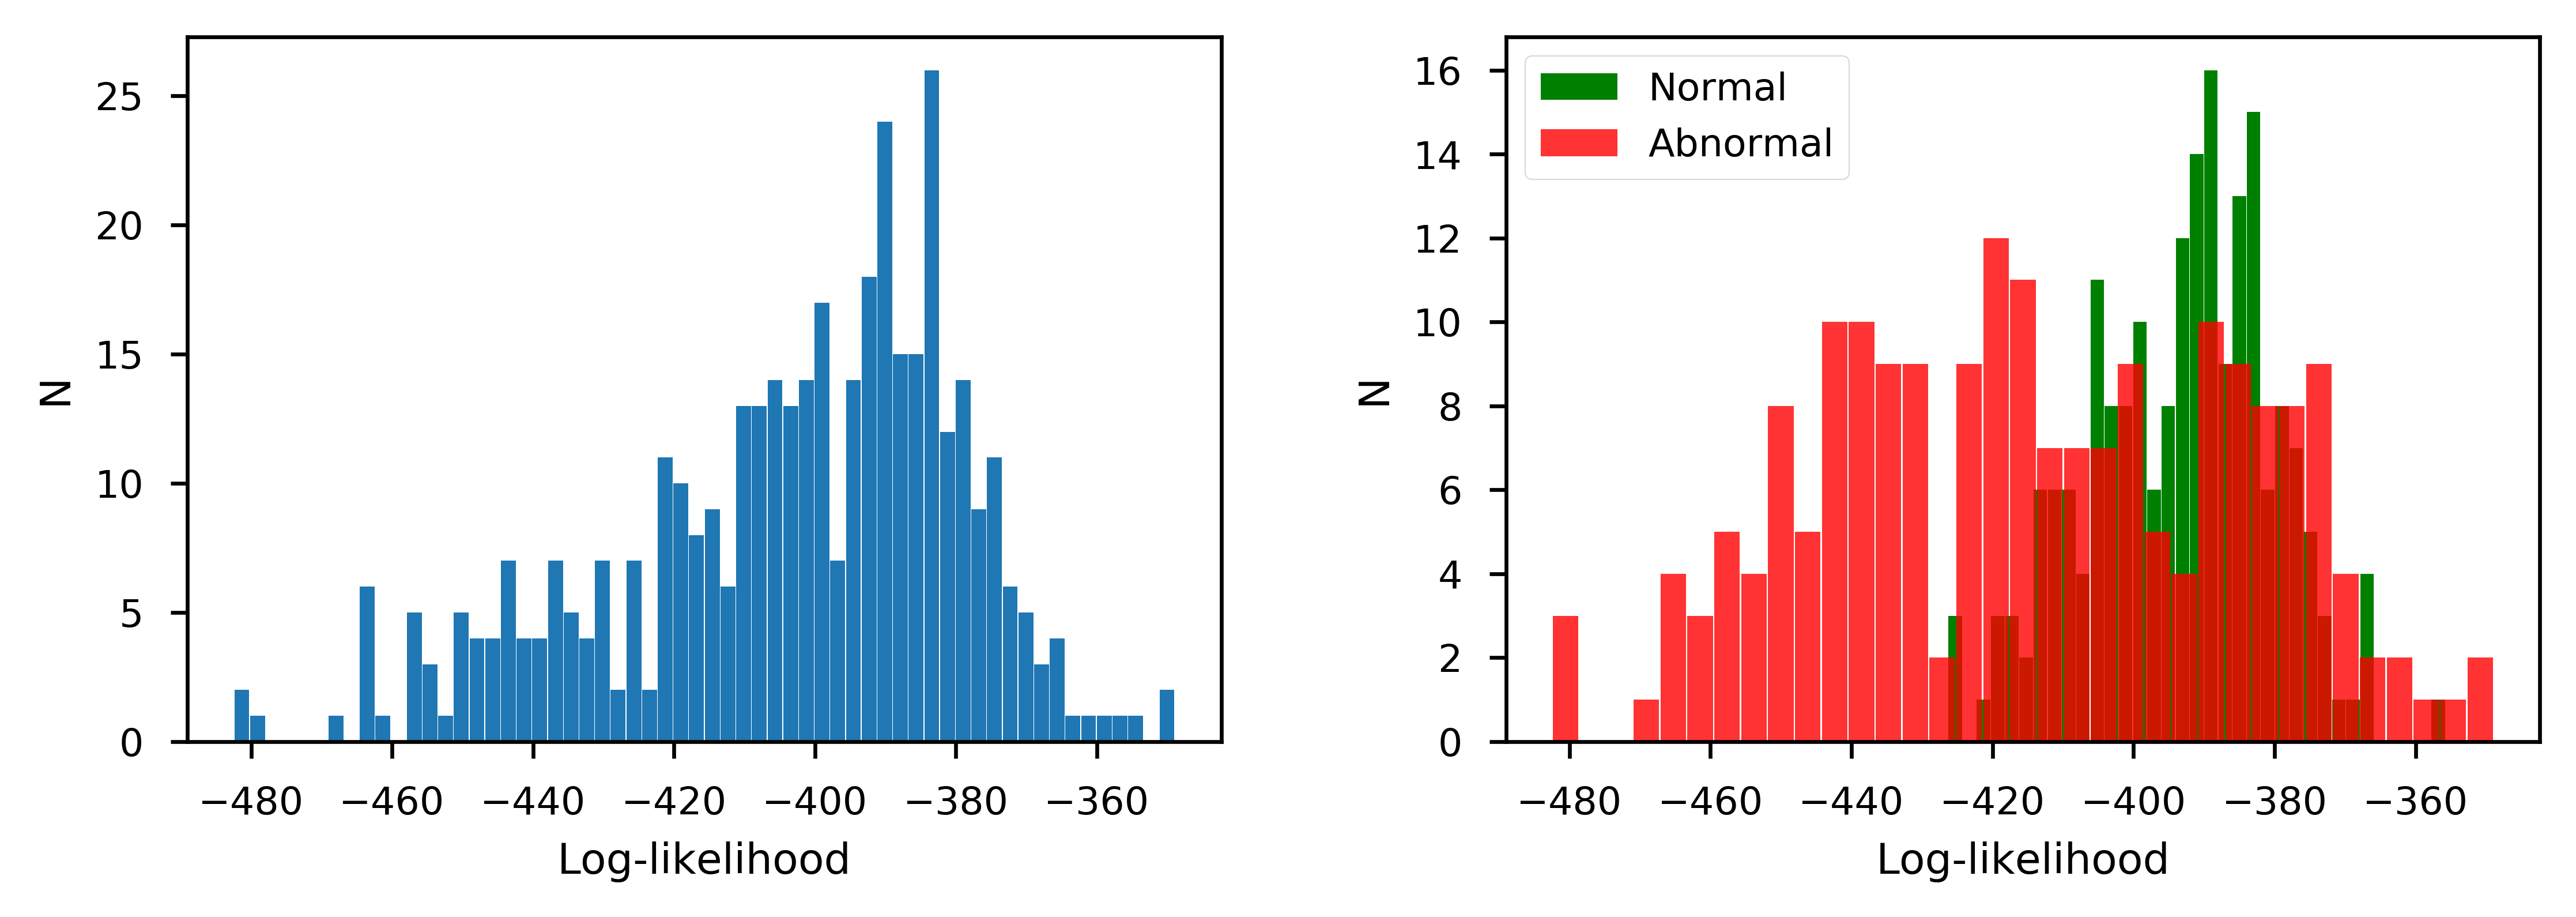

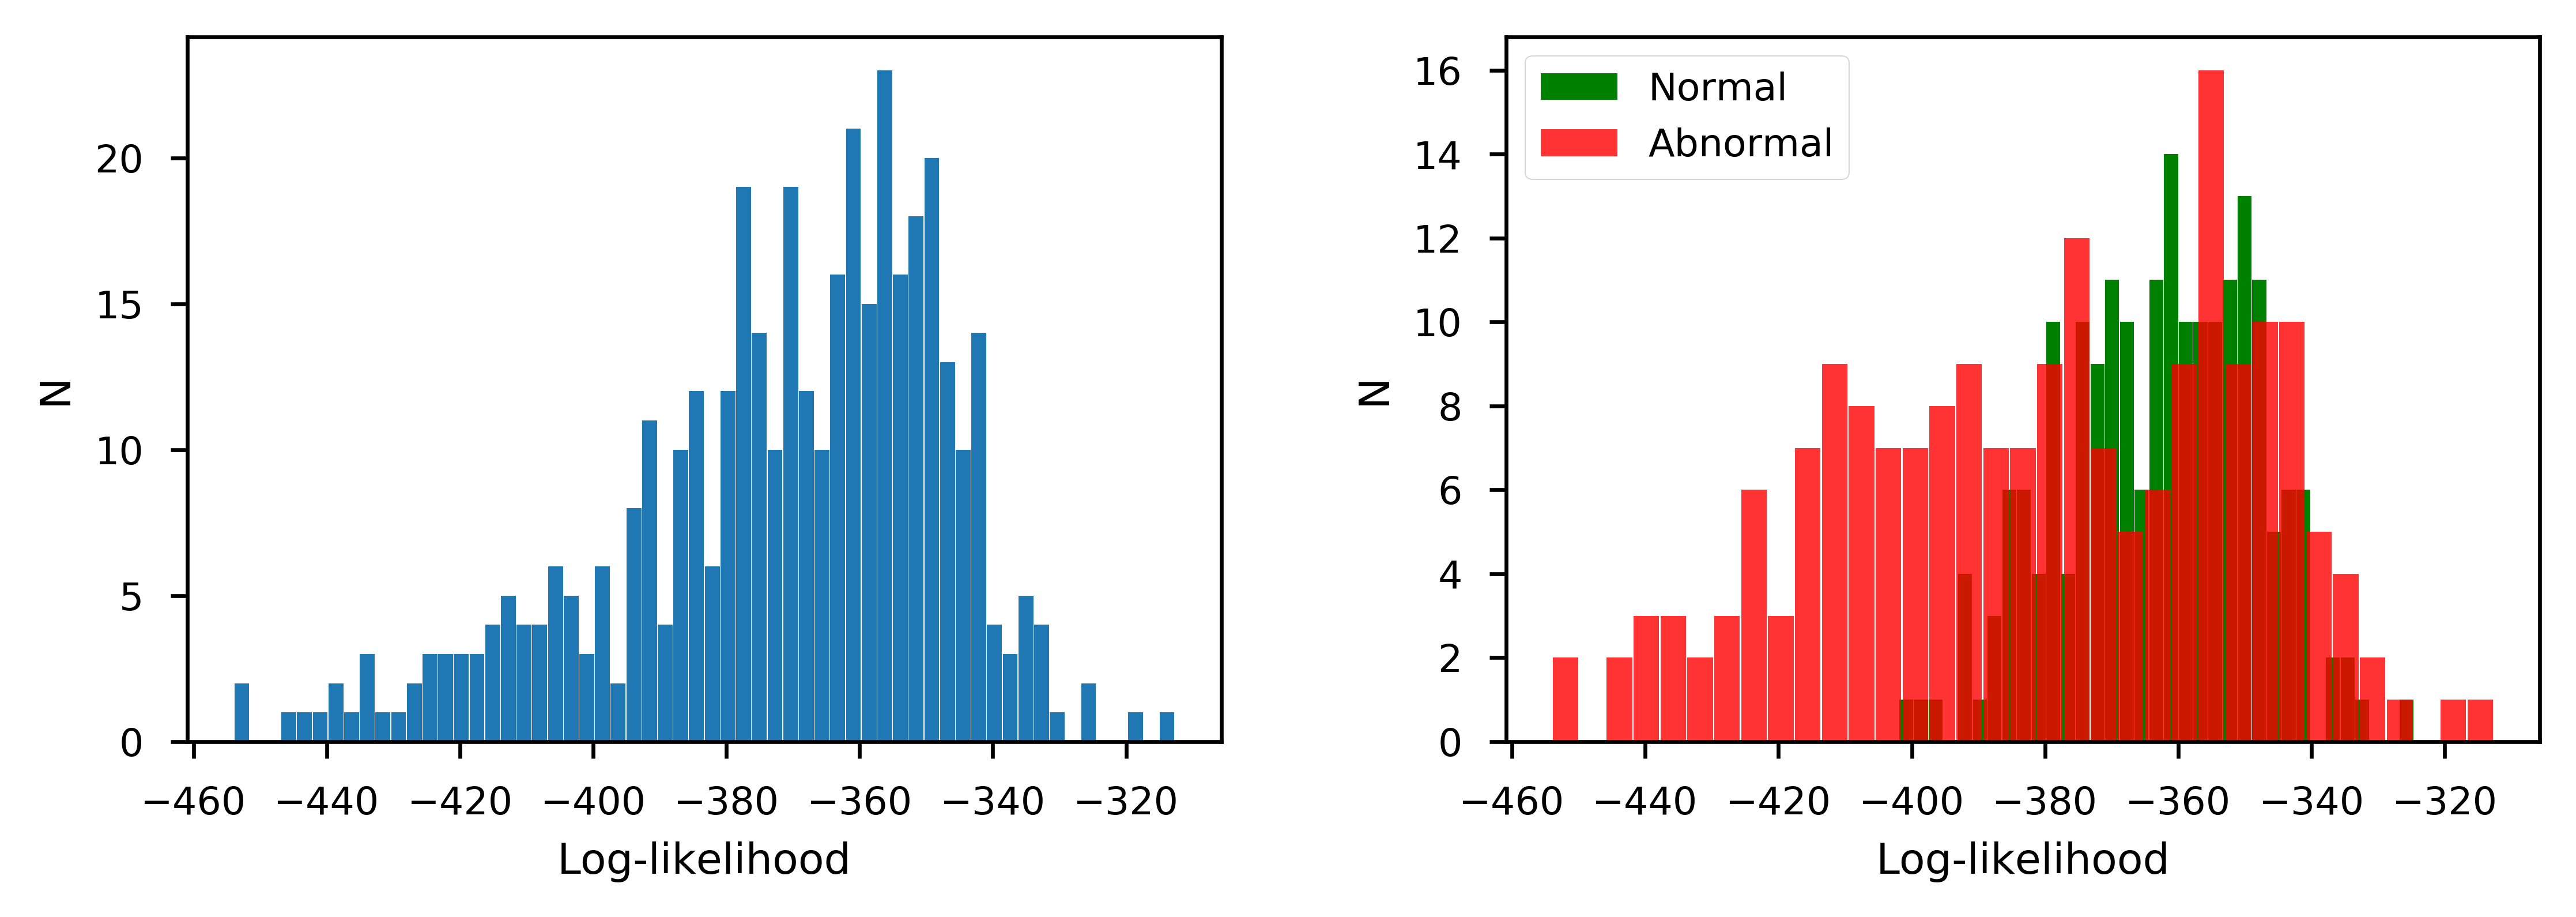

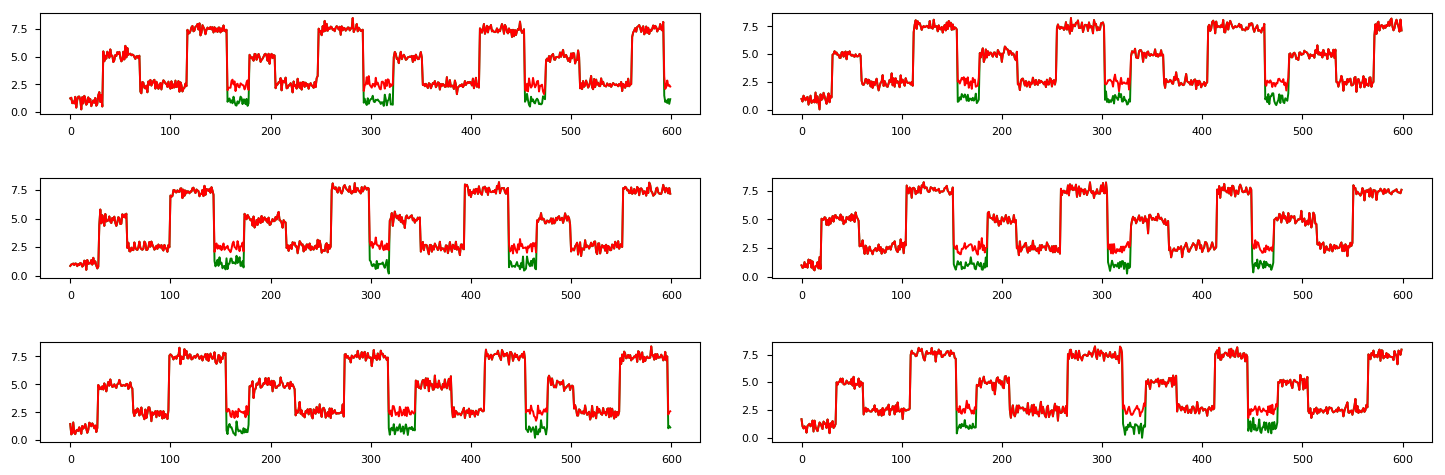

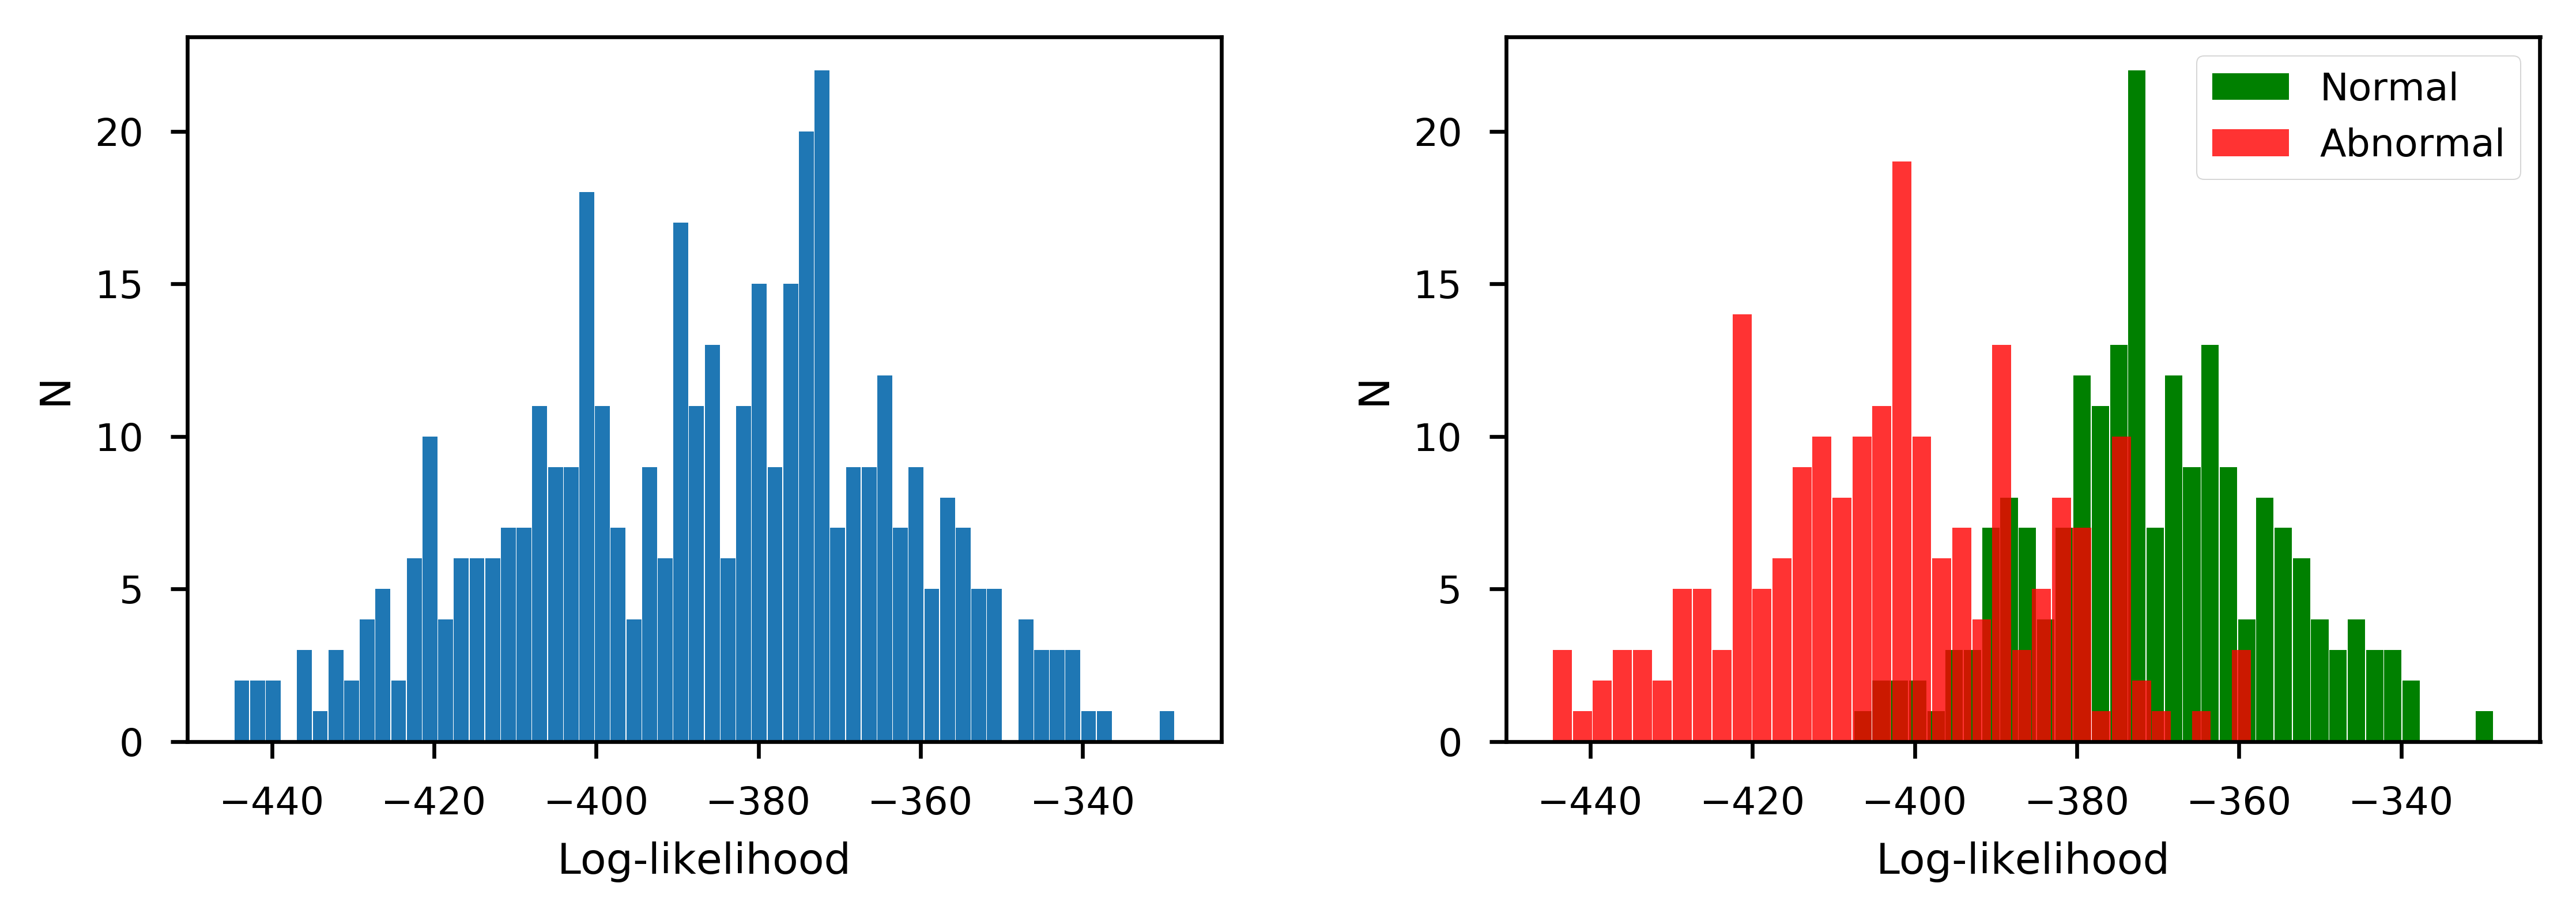

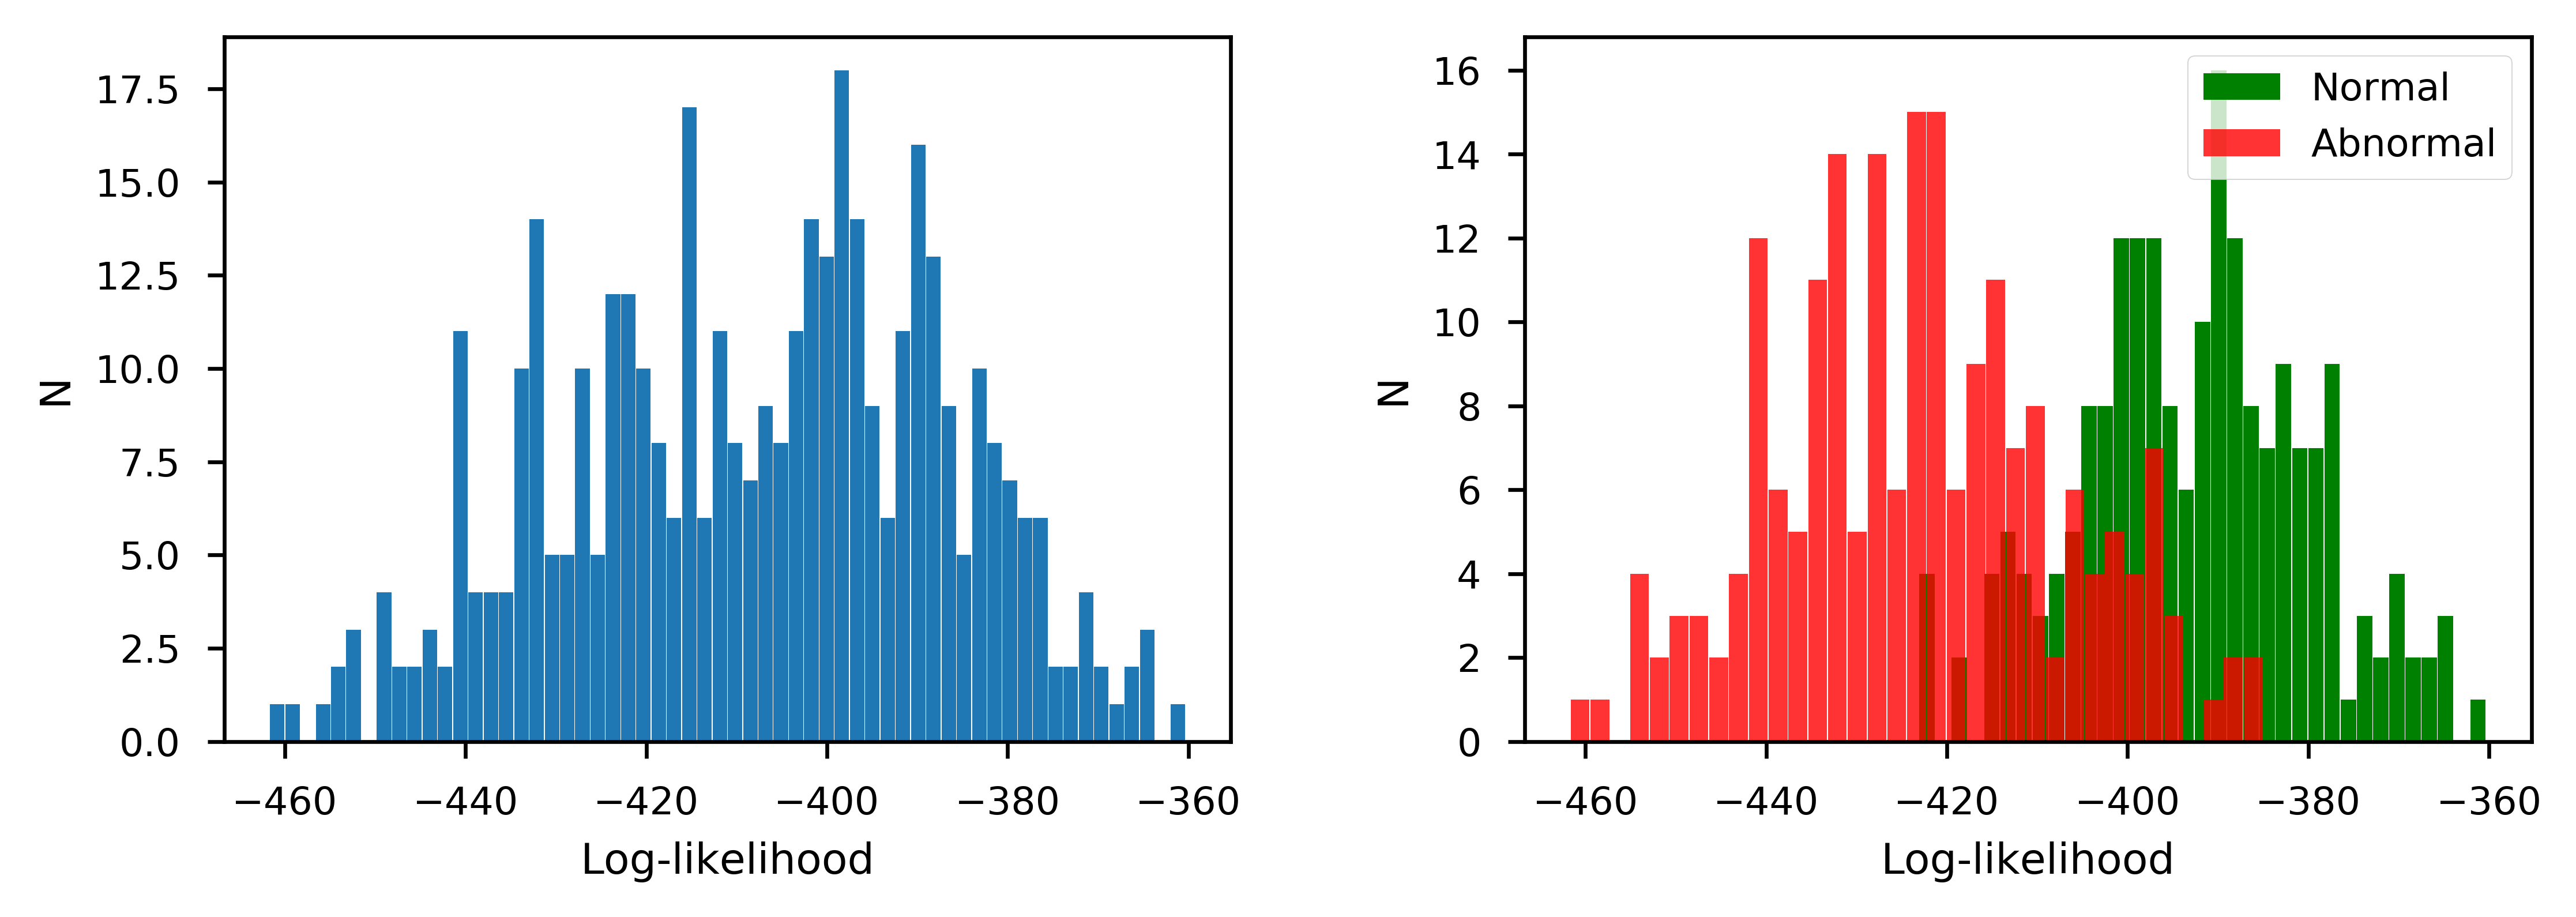

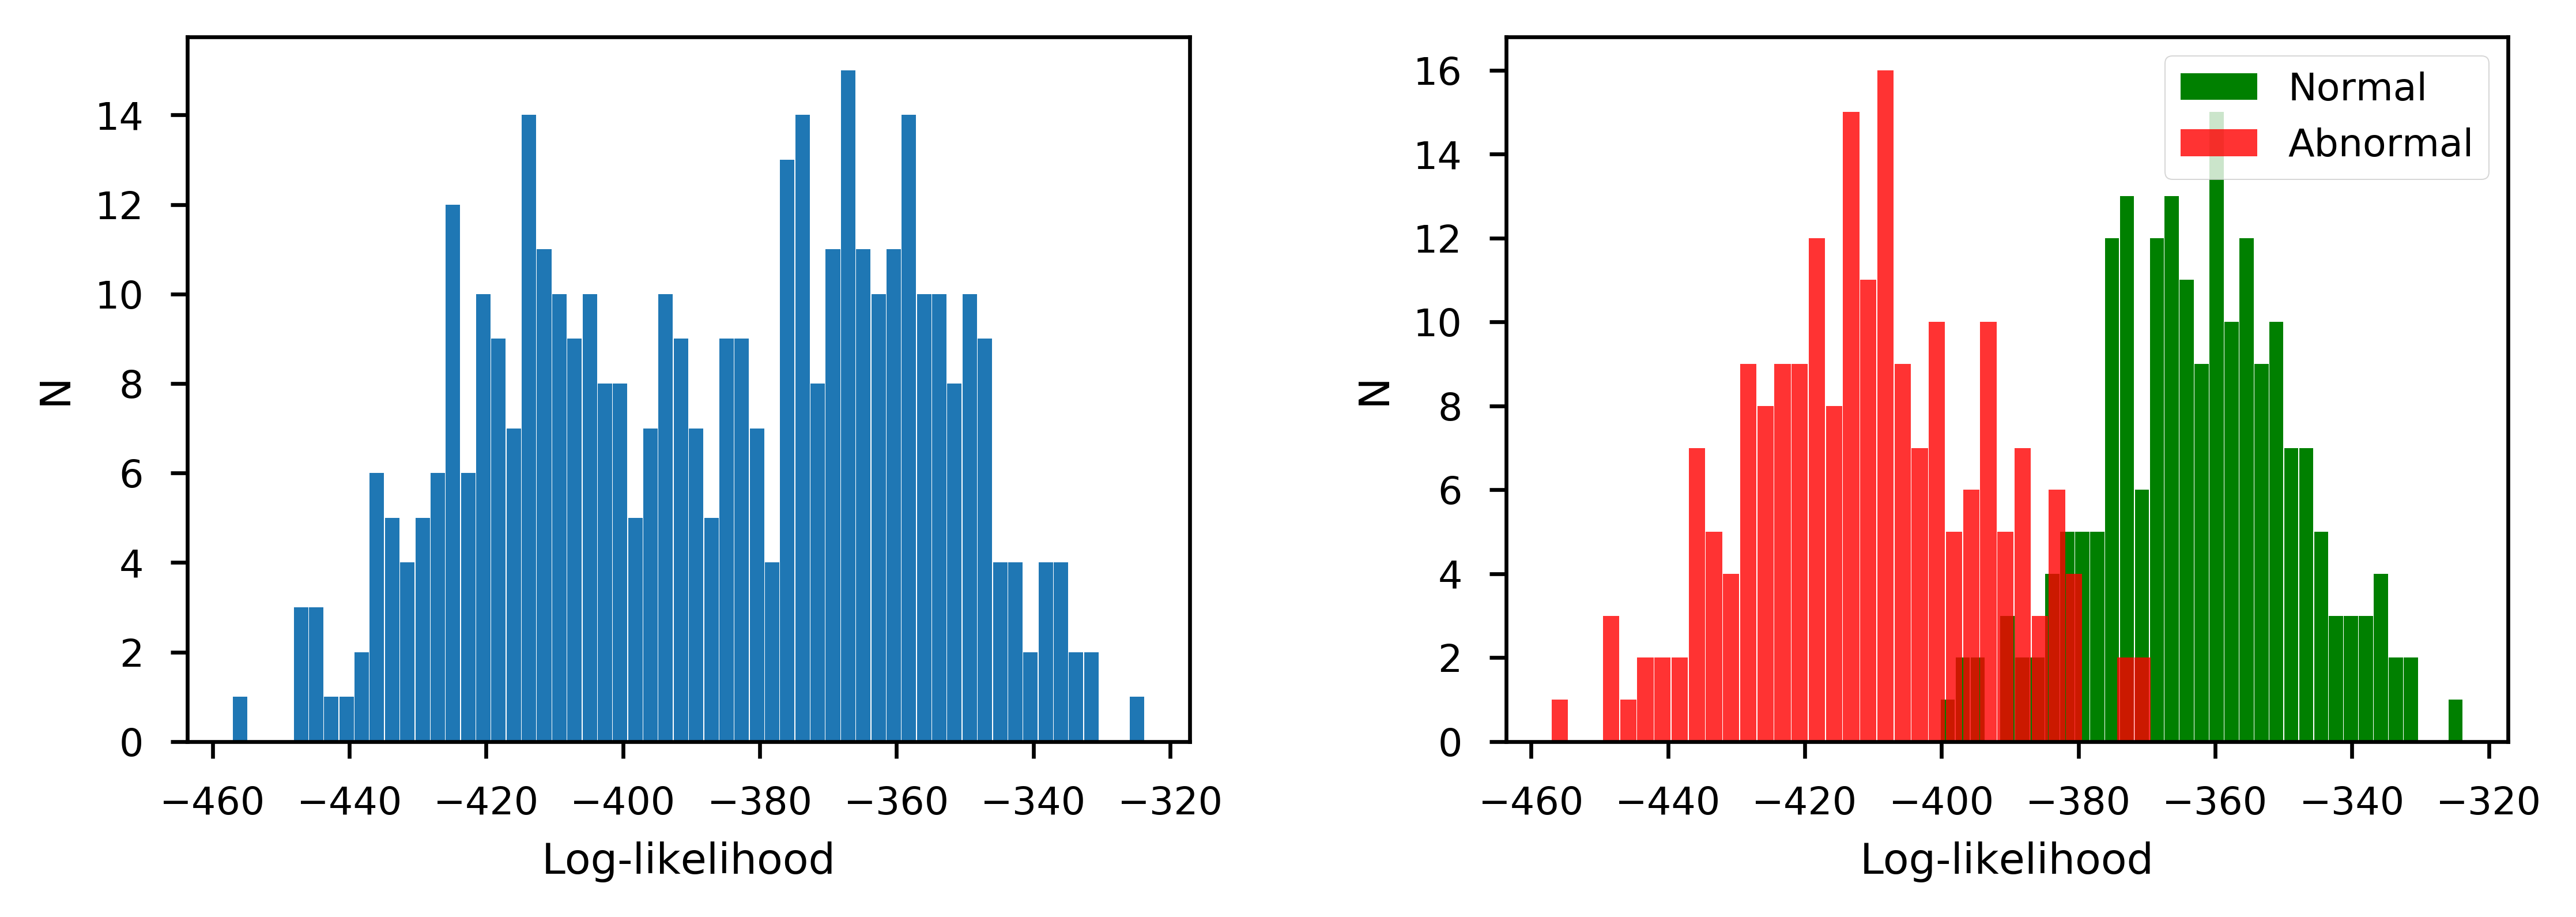

In [181]:
M = 200
for type_anomal in list_of_anomalies:
    print(type_anomal)
    x_test = []
    y_true = np.array([0]*M+[1]*M)
    normal_signals = []
    abnormal_signals = []
    for i in range(M):
        normal_signals+=[signal.generate_signal().copy()]
        if type_anomal == 'varience':
            abnormal_signals+=[signal.get_abnormal(dtype = type_anomal,state = [0,2], varience_coef=2.5).copy()]
        elif type_anomal == 'extension':
            abnormal_signals+=[signal.get_abnormal(dtype = type_anomal,extension_coef = 2.5).copy()]
        elif type_anomal == 'chain_violation':
            abnormal_signals+=[signal.get_abnormal(dtype = type_anomal, state=0, state_update=2,
                                           count_segment= 12).copy()]
            
    print(len(normal_signals), len(abnormal_signals))
    x_test = np.concatenate((normal_signals, abnormal_signals))
    # for i in range(M):
    # #     signal.generate_signal()
    #     x_test +=[signal.get_abnormal(dtype = 'varience',state = [0,2], varience_coef=2.5)]

    print(len(x_test),len(x_test[0]))
    
    fig = plt.figure(figsize=(15,10), dpi = 100)
    for i,(x,y) in enumerate(zip(x_test,x_test[M:M+6])):
        ax = plt.subplot(6,2,i+1)
        plt.plot(x,'g')
        plt.plot(y,'r-')
    plt.tight_layout()
    plt.savefig('./'+type_anomal+'Сигналы.tif', quality = 100, dpi = 300)
    
#Расчет лог.правдоподобия
    pool = Pool()
    x_test = np.array(x_test)
    ll = pool.map(do_log_likelihood, [ (m, x_test) for m in classifiear.models])
    pool.close()
    pool.join()
    
    for model_number in range(classifiear.number_model):
        fig = plt.figure(figsize=(8,3.2), dpi = 600,)

        plt.subplot(1,2,1)
        plt.hist(ll[model_number], 60,rwidth = 0.95);
        plt.ylabel('N')
        plt.xlabel('Log-likelihood')
        # plt.axvline(low_lvl,color='black',label='Threshold')


        plt.subplot(1,2,2)
        # plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12);
        plt.hist(ll[model_number][y_true == 0],35,rwidth = 0.95, color='green',label='Normal');
        # plt.axvline(x=classifiear.models[5].log_likelihood(signal[:T]))
        # plt.axvline(low_lvl,color='black', label='Threshold')
        plt.ylabel('N')
        plt.xlabel('Log-likelihood')
        #для аномальных
        plt.hist(ll[model_number][y_true == 1],35,color = 'r',alpha = 0.8, rwidth = 0.95,label='Abnormal');

        plt.legend();
        plt.tight_layout();

        plt.savefig('./'+str(type_anomal)+'/Гистограмма_'+str(model_number)+'.tif', dpi = 600,quality=100);
        
#Сохранение значений log_prob
    for i in range(len(ll)):
        if i == 0:
            ll_to_save = ll[i]
        else:
            ll_to_save = np.vstack((ll_to_save,ll[i]))
    ll_to_save = ll_to_save.T
    np.save('./'+type_anomal+'/log_prob.npy',ll_to_save)
    del x_test
    del ll
    del ll_to_save

### Генерация тестовых данных {400}

200 200
400 600


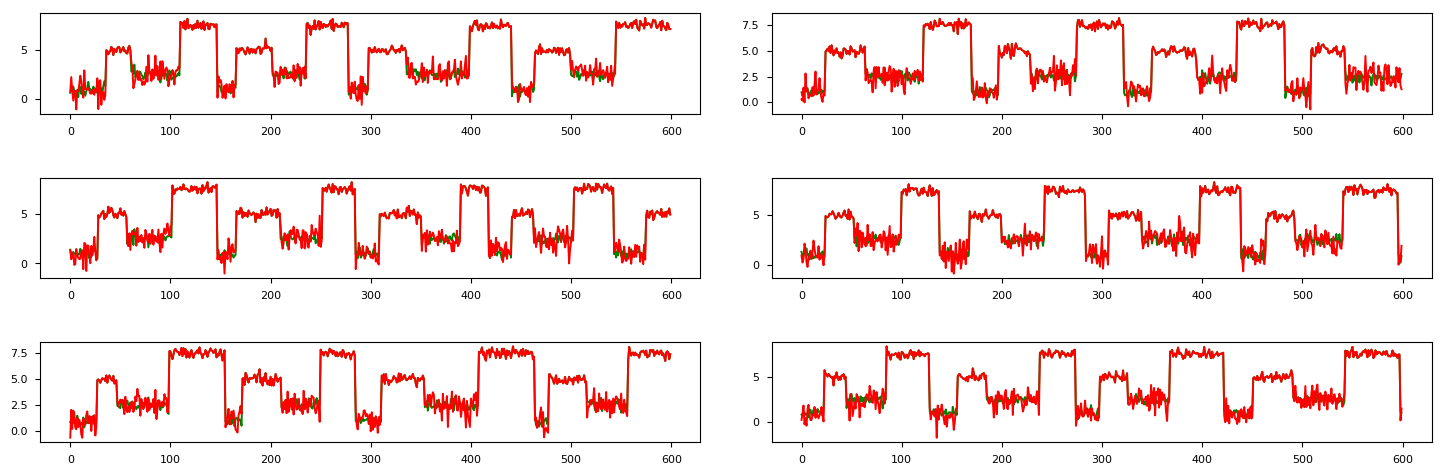

In [17]:
# x_test = []
M = 200
np.random.seed(42)
y_true = np.array([0]*M+[1]*M)
normal_signals = []
abnormal_signals = []
for i in range(M):
    normal_signals+=[signal.generate_signal().copy()]
    abnormal_signals+=[signal.get_abnormal(dtype = 'varience',state = [0,2], varience_coef=2.5).copy()]
print(len(normal_signals), len(abnormal_signals))
x_test = np.concatenate((normal_signals, abnormal_signals))
# for i in range(M):
# #     signal.generate_signal()
#     x_test +=[signal.get_abnormal(dtype = 'varience',state = [0,2], varience_coef=2.5)]

print(len(x_test),len(x_test[0]))
fig = plt.figure(figsize=(15,10), dpi = 100)
for i,(x,y) in enumerate(zip(x_test,x_test[M:M+6])):
    ax = plt.subplot(6,2,i+1)
    plt.plot(x,'g')
    plt.plot(y,'r-')
plt.tight_layout()
plt.show()


# Сохранить эту картинку

### Подсчет log_prob

In [15]:
pool = Pool()
x_test = np.array(x_test)
ll = pool.map(do_log_likelihood, [ (m, x_test) for m in classifiear.models])
pool.close()
pool.join()

/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


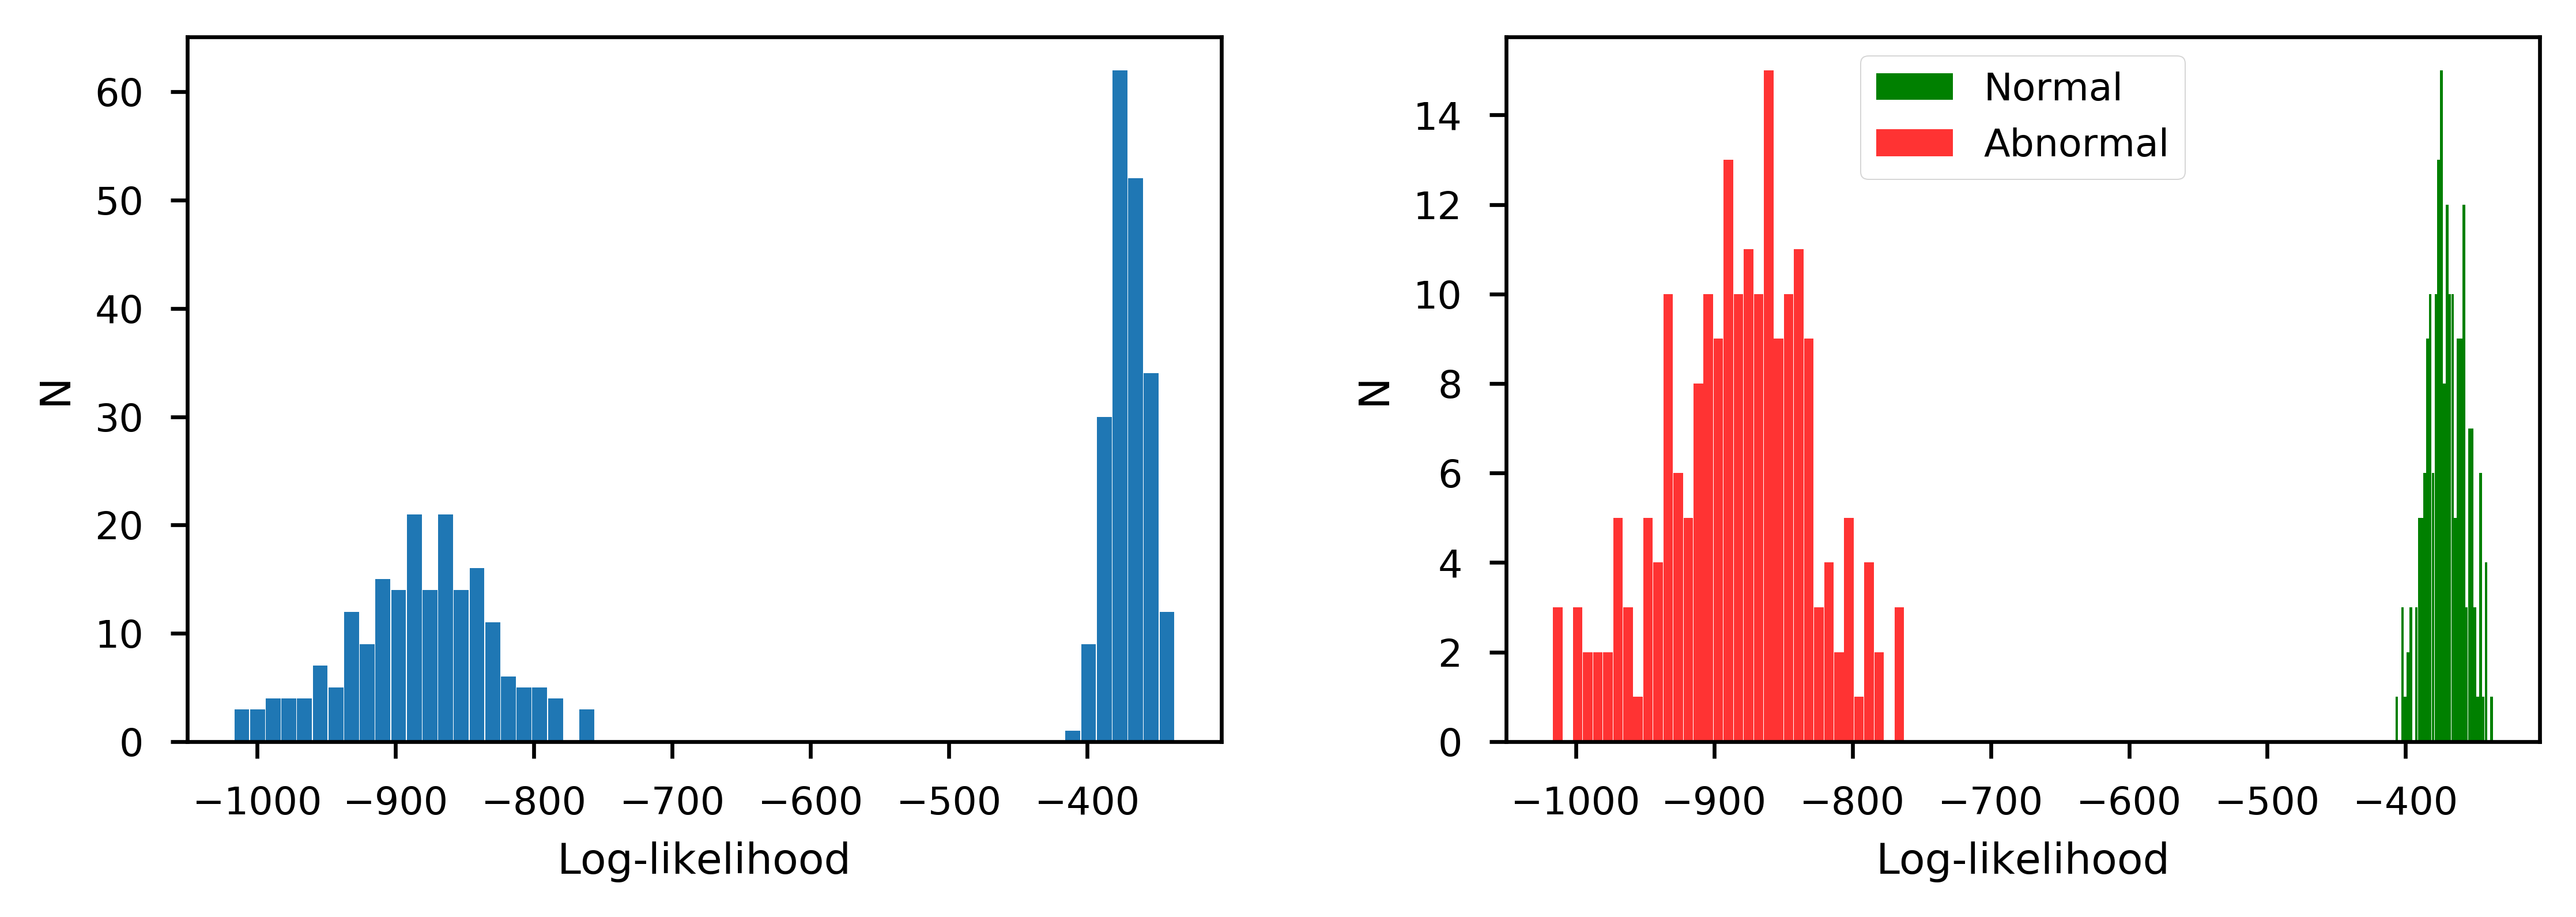

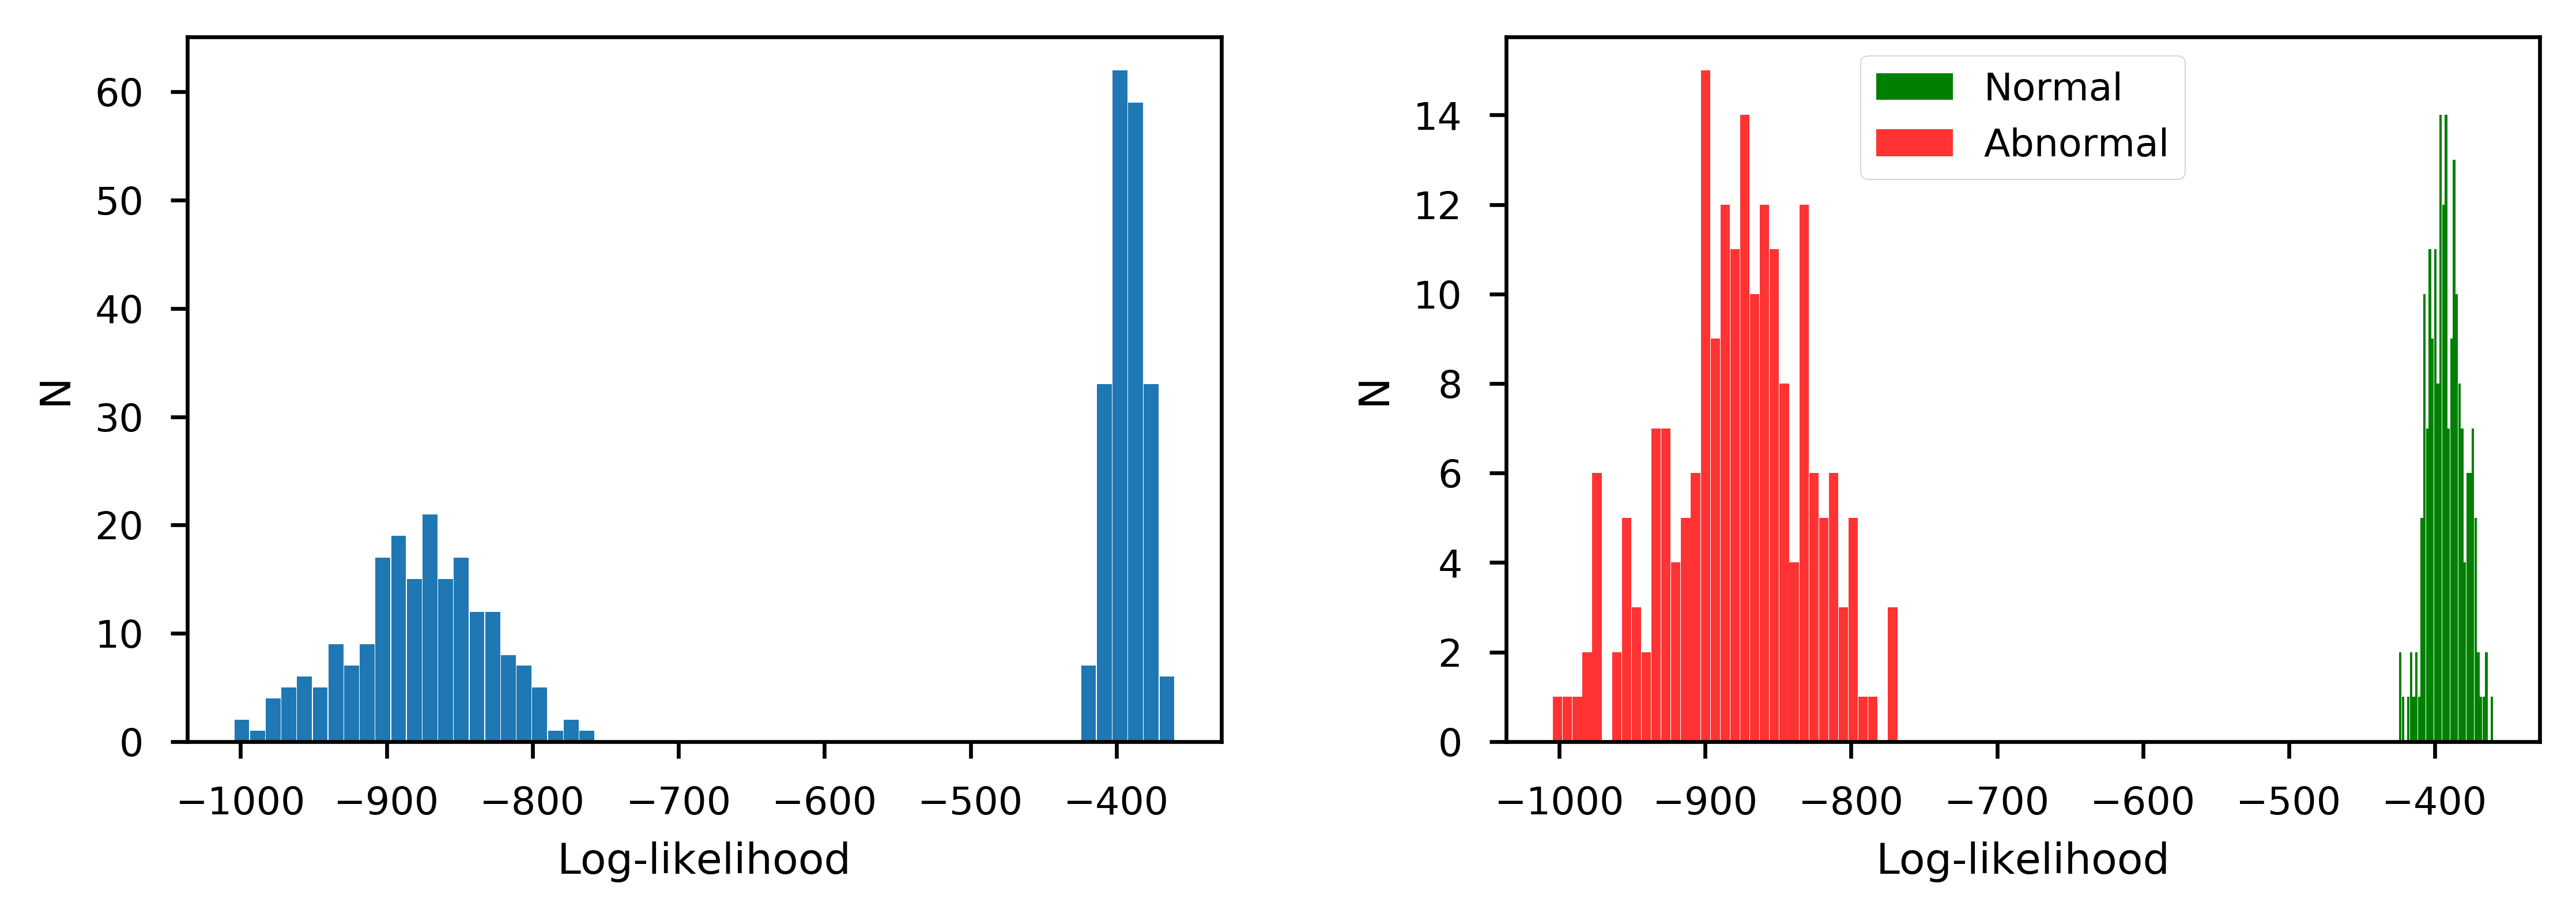

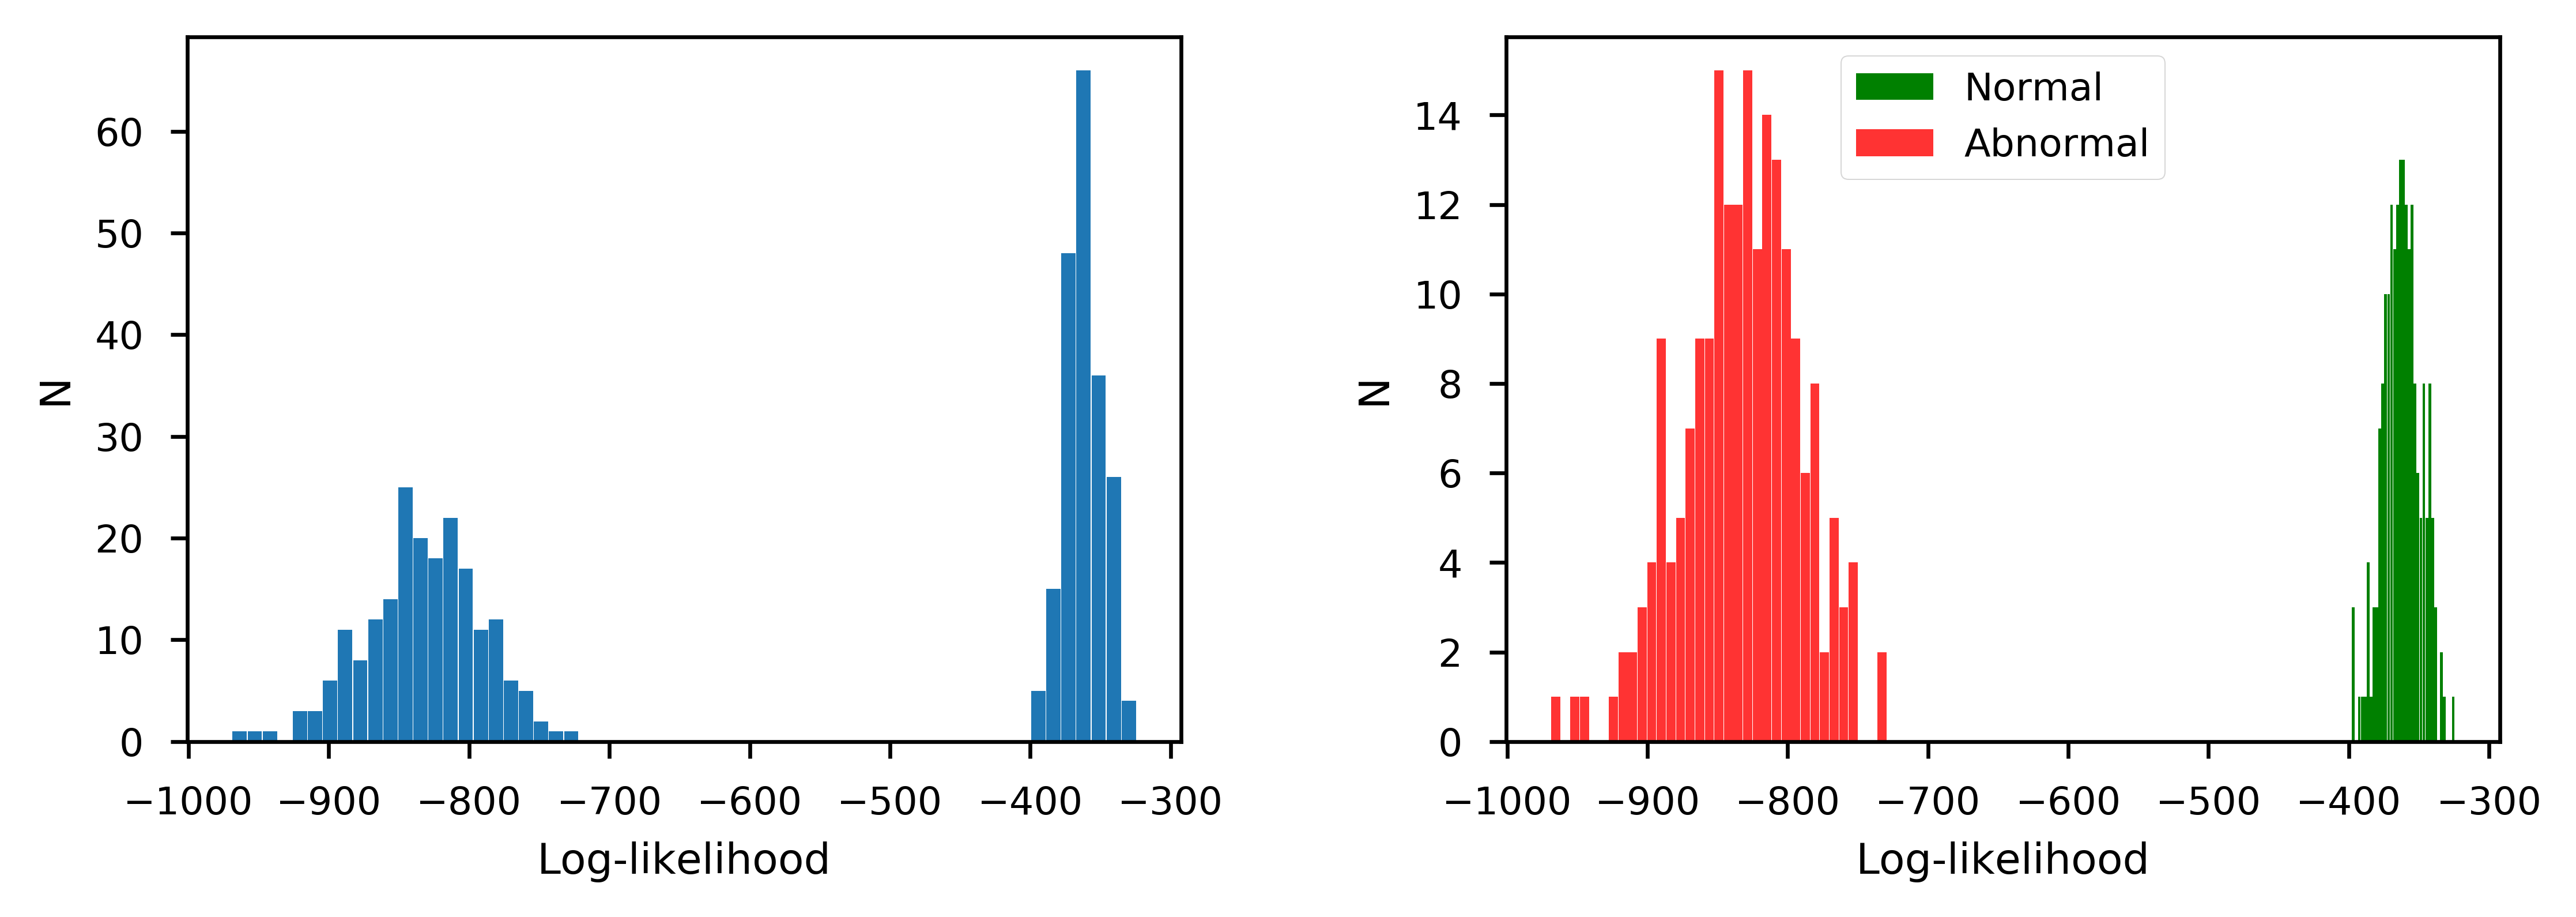

In [23]:
model_number = 0
for model_number in range(classifiear.number_model):
    fig = plt.figure(figsize=(8,3.2), dpi = 600,)
    plt.style.use('seaborn-paper')
    matplotlib.rcParams['font.size'] = 25
    plt.subplot(1,2,1)
    plt.hist(ll[model_number], 60,rwidth = 0.95);
    plt.ylabel('N')
    plt.xlabel('Log-likelihood')
    # plt.axvline(low_lvl,color='black',label='Threshold')


    plt.subplot(1,2,2)
    # plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12);
    plt.hist(ll[model_number][y_true == 0],35,rwidth = 0.95, color='green',label='Normal');
    # plt.axvline(x=classifiear.models[5].log_likelihood(signal[:T]))
    # plt.axvline(low_lvl,color='black', label='Threshold')
    plt.ylabel('N')
    plt.xlabel('Log-likelihood')
    #для аномальных
    plt.hist(ll[model_number][y_true == 1],35,color = 'r',alpha = 0.8, rwidth = 0.95,label='Abnormal');

    plt.legend();
    plt.tight_layout();

    plt.savefig('./Varience/Гистограмма_'+str(model_number)+'.tif', dpi = 600,quality=100);

In [59]:
#Сохранение значений log_prob
for i in range(len(ll)):
    if i == 0:
        ll_to_save = ll[i]
    else:
        ll_to_save = np.vstack((ll_to_save,ll[i]))
ll_to_save = ll_to_save.T
np.save('log_prob.npy',ll_to_save)

NameError: name 'll' is not defined

In [58]:
del x_test
del ll
del ll_to_save

In [158]:
a = np.arange(10)
b = np.arange(15)
a[6:] = b[:(len(a)-6)]

200 200
400 600


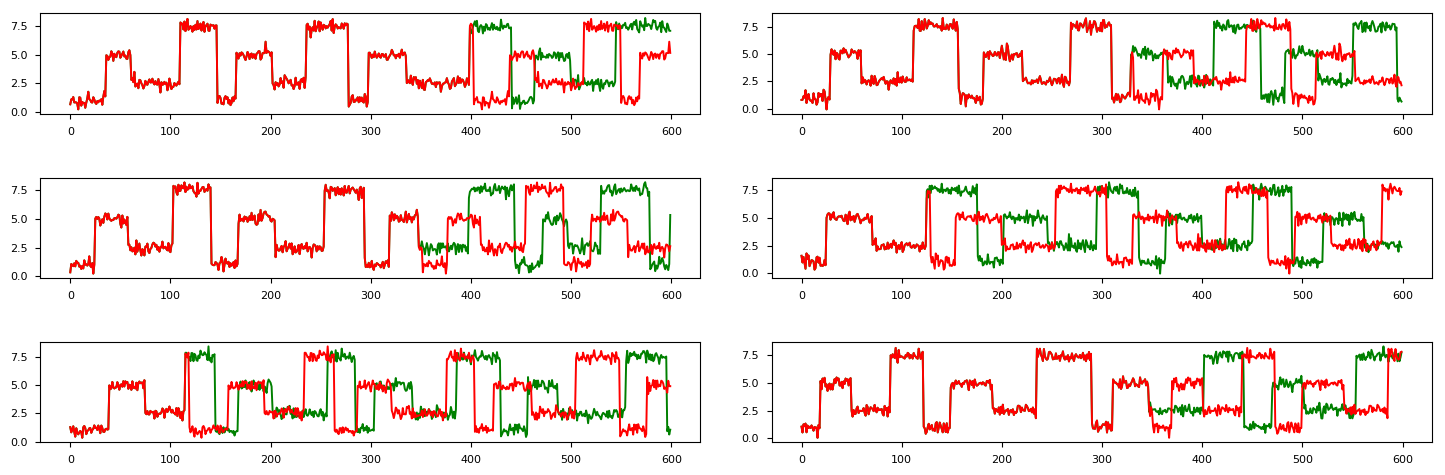

In [166]:
### Генерация тестовых данных {400}

# x_test = []
M = 200
np.random.seed(42)
y_true = np.array([0]*M+[1]*M)
normal_signals = []
abnormal_signals = []
for i in range(M):
    normal_signals+=[signal.generate_signal().copy()]
    abnormal_signals+=[signal.get_abnormal(dtype = 'extension', extension_coef=0.1).copy()]
print(len(normal_signals), len(abnormal_signals))
x_test = np.concatenate((normal_signals, abnormal_signals))
# for i in range(M):
# #     signal.generate_signal()
#     x_test +=[signal.get_abnormal(dtype = 'varience',state = [0,2], varience_coef=2.5)]

print(len(x_test),len(x_test[0]))
fig = plt.figure(figsize=(15,10), dpi = 100)
for i,(x,y) in enumerate(zip(x_test,x_test[M:M+6])):
    ax = plt.subplot(6,2,i+1)
    plt.plot(x,'g')
    plt.plot(y,'r-')
plt.tight_layout()
plt.show()

# Сохранить эту картинку


/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


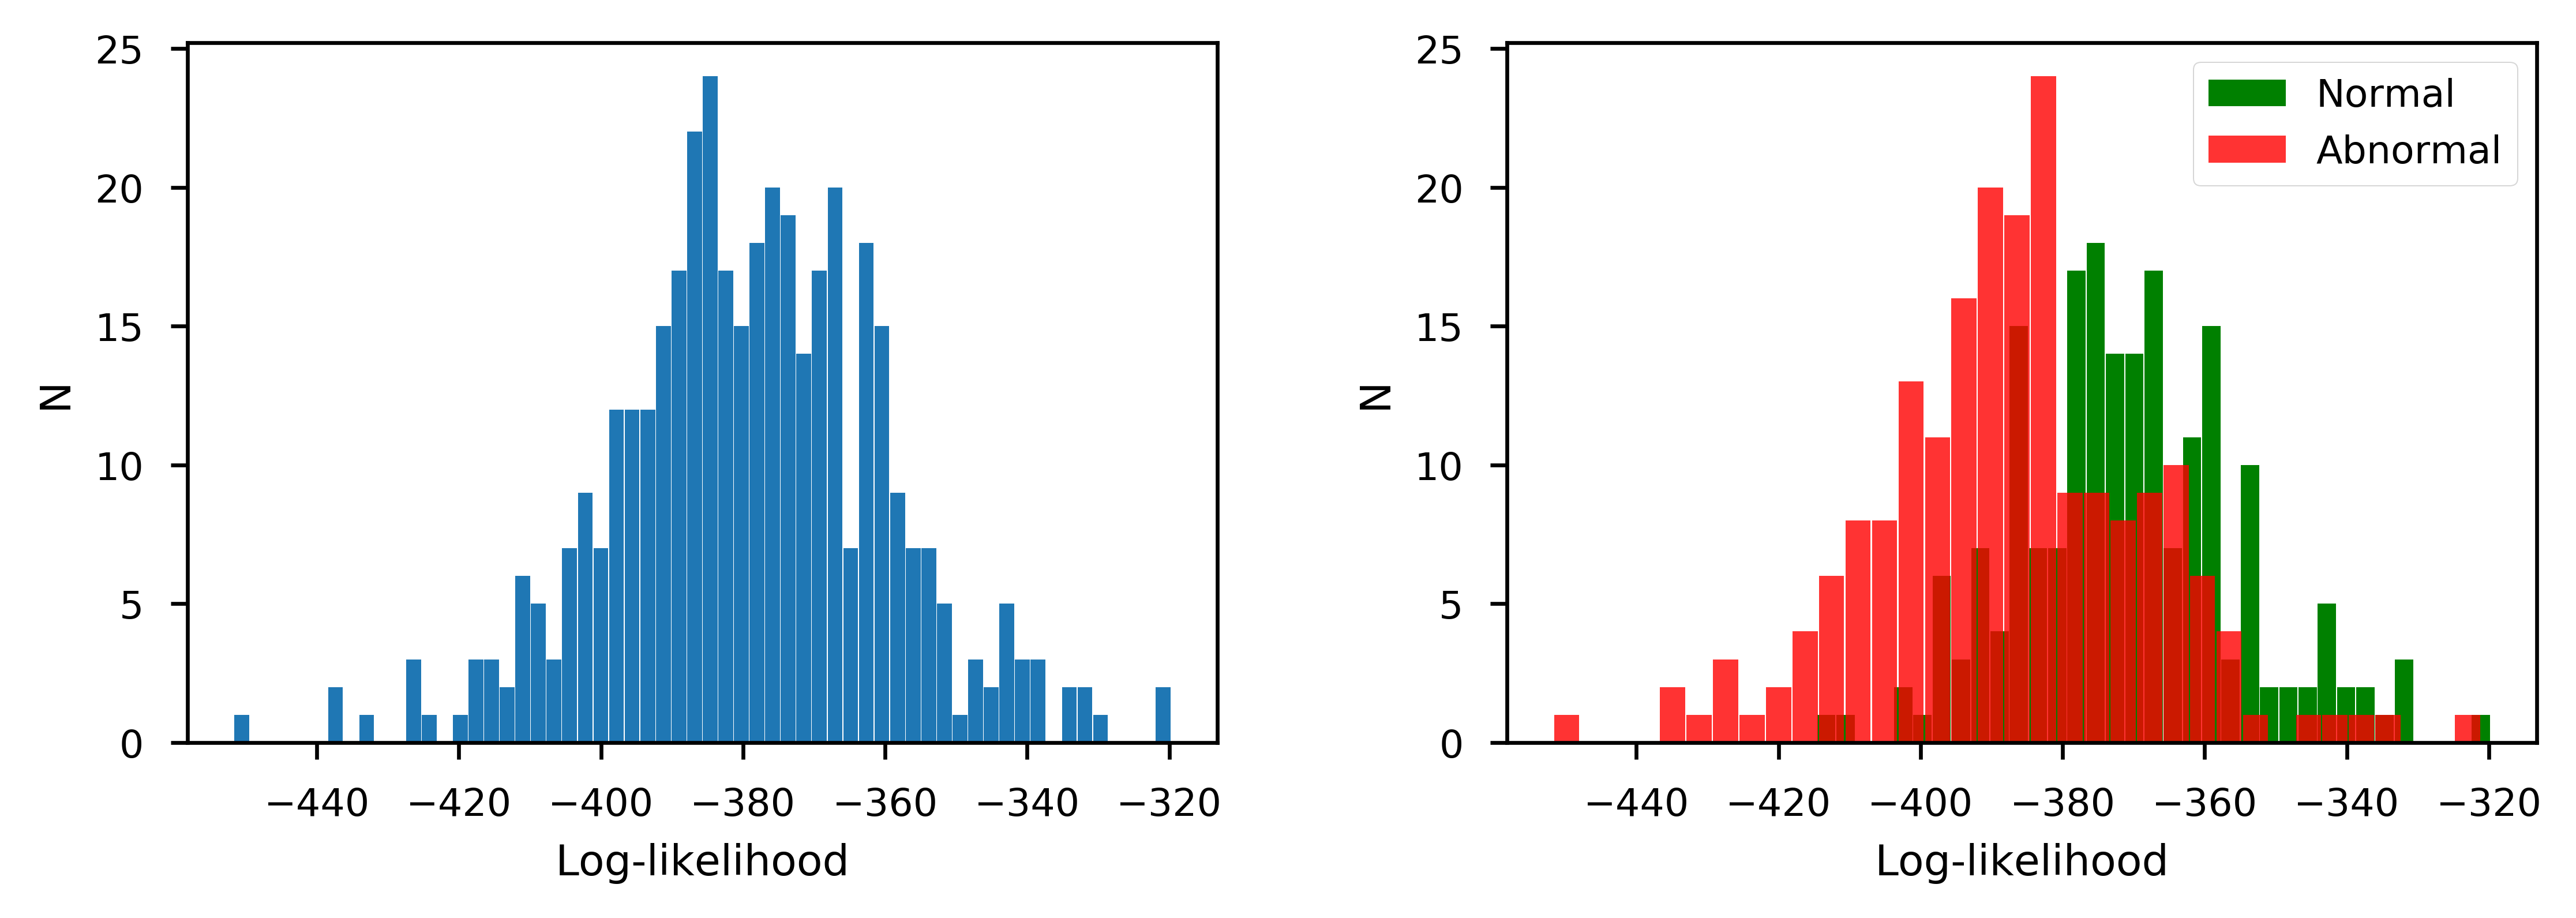

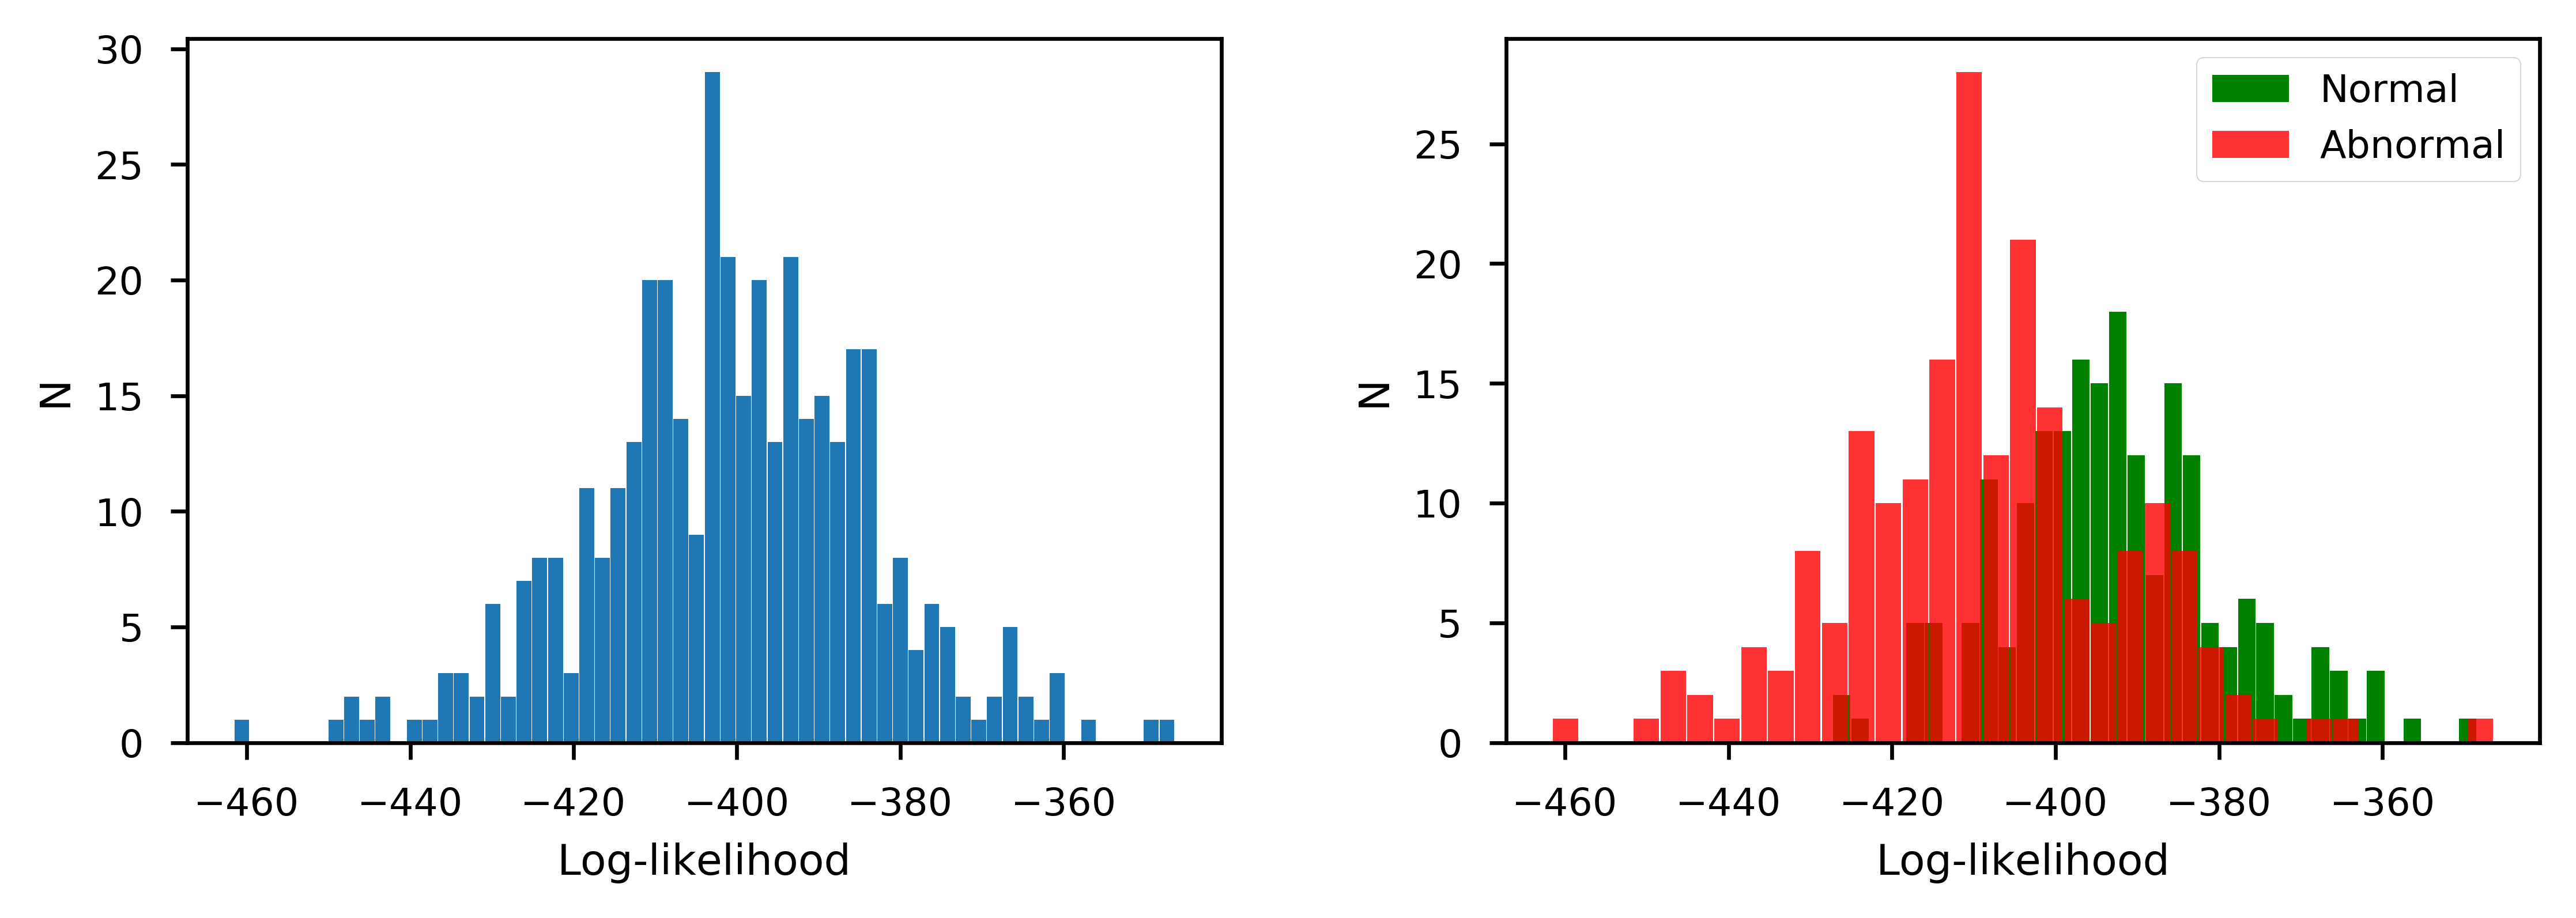

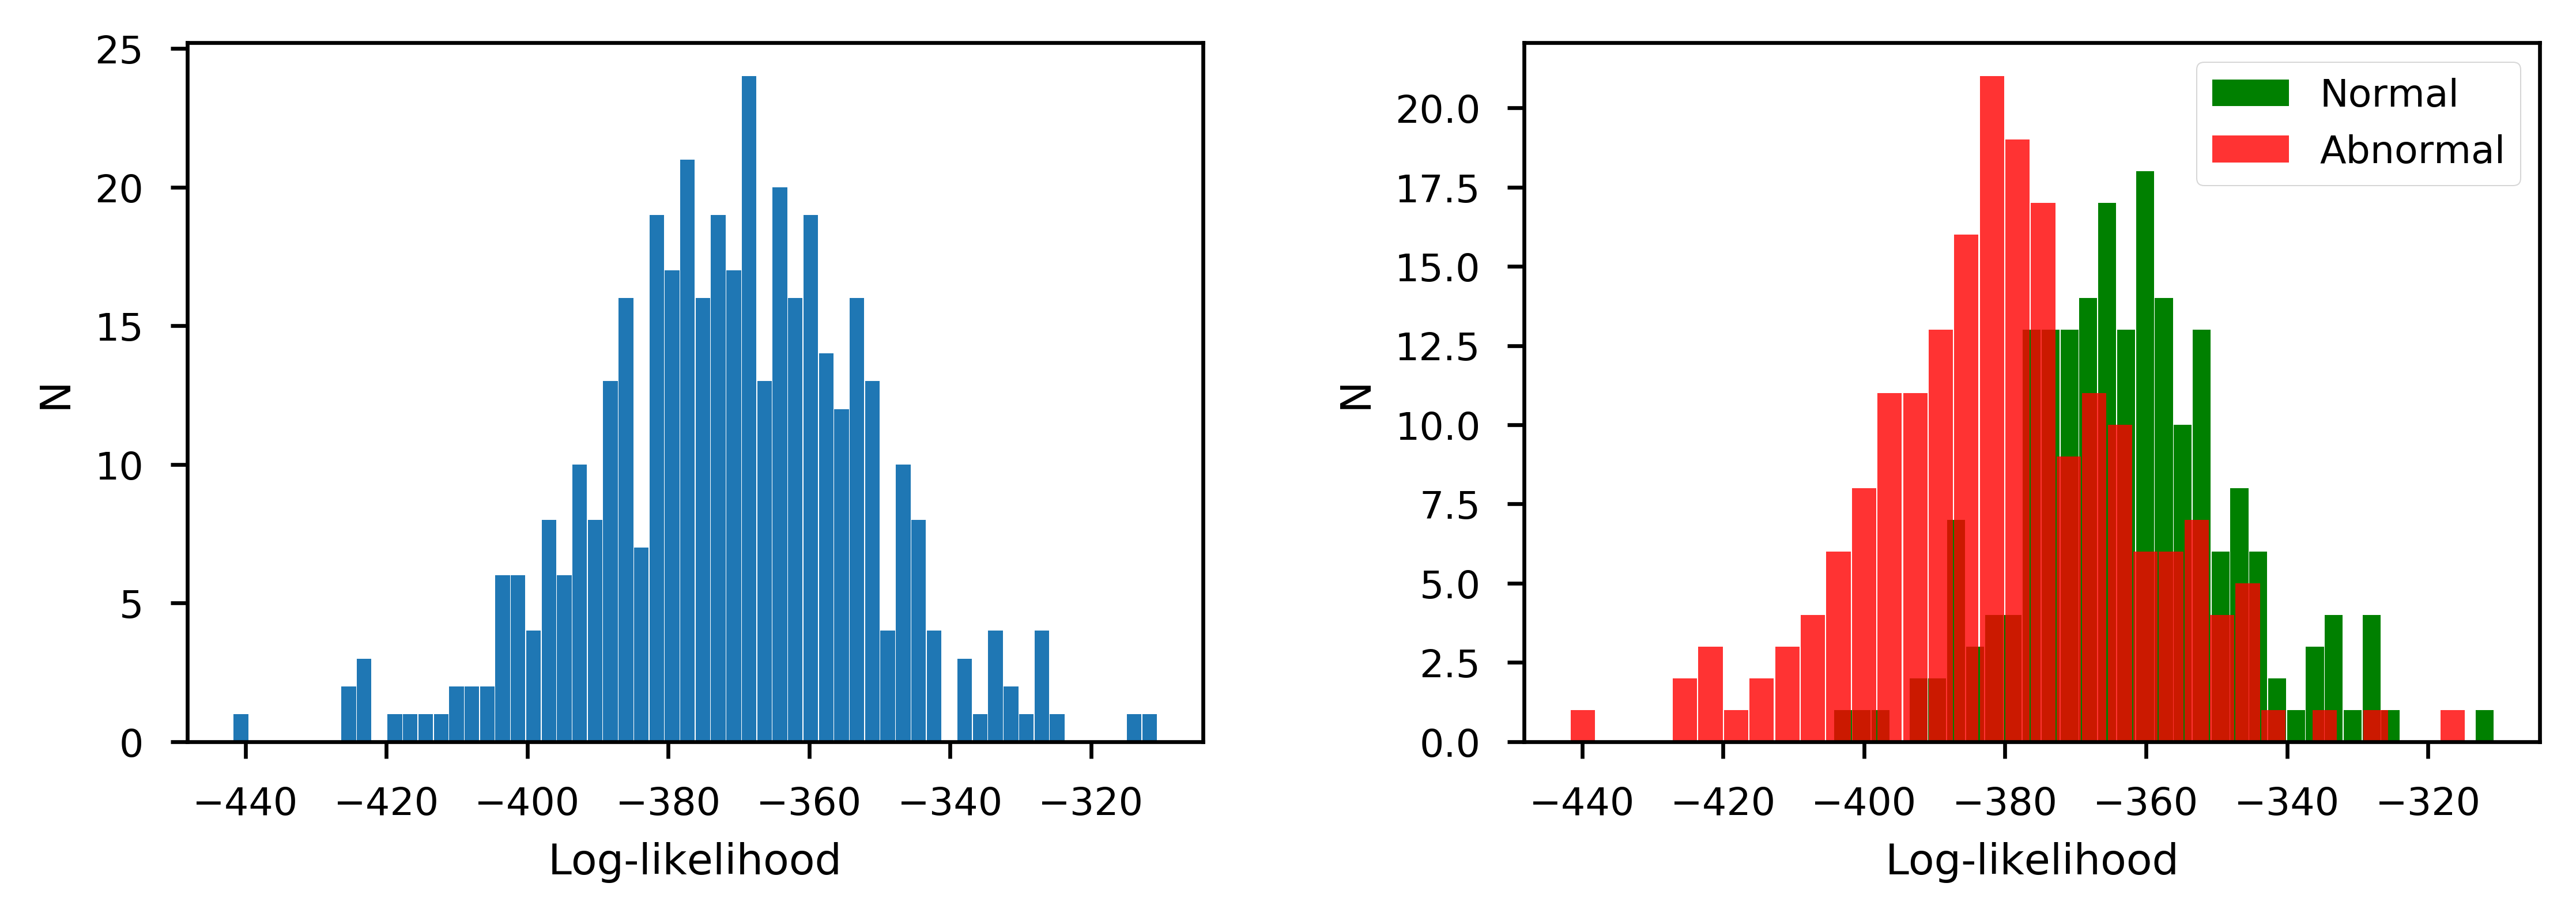

In [167]:
### Подсчет log_prob

pool = Pool()
x_test = np.array(x_test)
ll = pool.map(do_log_likelihood, [ (m, x_test) for m in classifiear.models])
pool.close()
pool.join()

model_number = 0
for model_number in range(classifiear.number_model):
    fig = plt.figure(figsize=(8,3.2), dpi = 600,)
    plt.style.use('seaborn-paper')
    matplotlib.rcParams['font.size'] = 25
    plt.subplot(1,2,1)
    plt.hist(ll[model_number], 60,rwidth = 0.95);
    plt.ylabel('N')
    plt.xlabel('Log-likelihood')
    # plt.axvline(low_lvl,color='black',label='Threshold')


    plt.subplot(1,2,2)
    # plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12);
    plt.hist(ll[model_number][y_true == 0],35,rwidth = 0.95, color='green',label='Normal');
    # plt.axvline(x=classifiear.models[5].log_likelihood(signal[:T]))
    # plt.axvline(low_lvl,color='black', label='Threshold')
    plt.ylabel('N')
    plt.xlabel('Log-likelihood')
    #для аномальных
    plt.hist(ll[model_number][y_true == 1],35,color = 'r',alpha = 0.8, rwidth = 0.95,label='Abnormal');

    plt.legend();
    plt.tight_layout();

    plt.savefig('./Extension/Гистограмма_'+str(model_number)+'.tif', dpi = 600,quality=100);

200 200
400 600


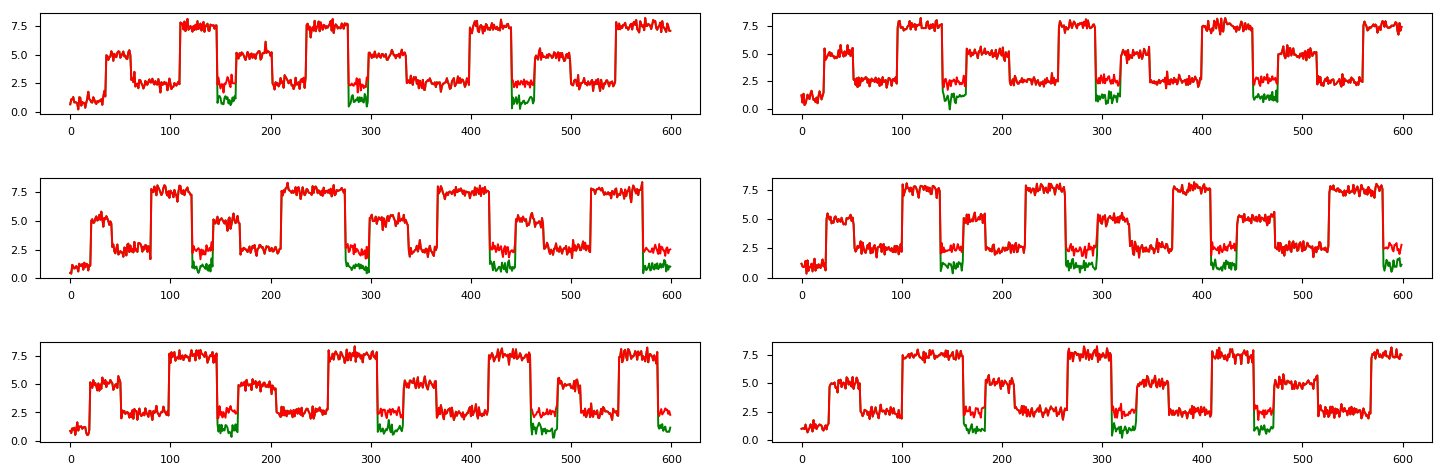

In [171]:
### Генерация тестовых данных {400}

# x_test = []
M = 200
np.random.seed(42)
y_true = np.array([0]*M+[1]*M)
normal_signals = []
abnormal_signals = []
for i in range(M):
    normal_signals+=[signal.generate_signal().copy()]
    abnormal_signals+=[signal.get_abnormal(dtype = 'chain_violation', state=0, state_update=2,
                                           count_segment= 12).copy()]
print(len(normal_signals), len(abnormal_signals))
x_test = np.concatenate((normal_signals, abnormal_signals))
# for i in range(M):
# #     signal.generate_signal()
#     x_test +=[signal.get_abnormal(dtype = 'varience',state = [0,2], varience_coef=2.5)]

print(len(x_test),len(x_test[0]))
fig = plt.figure(figsize=(15,10), dpi = 100)
for i,(x,y) in enumerate(zip(x_test,x_test[M:M+6])):
    ax = plt.subplot(6,2,i+1)
    plt.plot(x,'g')
    plt.plot(y,'r-')
plt.tight_layout()
plt.show()

# Сохранить эту картинку


In [183]:
classifiear.models[0]